<img align="left" width="20%" style="padding-right:10px;" src="./Images/Ccom.png"> 

# Integrated Seabed Mapping Systems <a href="https://teams.microsoft.com/l/channel/19%3Aff7ec351ff0c47c6bcfcf56eec17fac6%40thread.tacv2/Lab%20A?groupId=2eb37af4-381e-42ce-9734-96b67118b0e6&tenantId=d6241893-512d-46dc-8d2b-be47e25f5666"><img src="./Images/help.png"  title="Ask questions on Teams" align="right" width="10%" alt="Piazza.com\"></a><br><br> Lab A: Integration



***

# Purpose: Integration of Data Streams

For this lab you will navigate the transmitter and receiver of a multi-beam for the case of a (near) vertically oriented beam. This special case may be treated as a (narrow beam) single beam echo sounder through ignoring the array-relative angles of transmission and reception. 

The amount of work needed for this series of labs is significant. You will do some programming for all of the steps and will be asked some questions about the results along the way. If you have taken the course `ESCI 872: Tools for Ocean Mapping` some of this will look very familiar to you. If you have not: if you would have taken that course, you would have written some of the code (provided here for free) by yourself. Let me know if you are interested in doing the labs in which you would have written the code and I can provide them to you. 

In this first step (this `Lab A`) you will determine locations of the seafloor in geo-referenced coordinates. This requires the integration of position data from a point source sensor (either a **<ins>G</ins>lobal <ins>N</ins>avigation <ins>S</ins>atellite <ins>S</ins>ystem** (**GNSS**) receiver for a surface platform or an acoustic transponder for a submerged vehicle), measures of the instantaneous orientation of the vessel reference frame at transmission and reception of the acoustic signal by an **<ins>I</ins>nertial <ins>N</ins>avigation <ins>S</ins>ystem** (**INS**), and some information about the sound speed in the locale of the observations.

The sensors acquiring the three sets of real time observations (sonar-relative range, position, and orientation) are not co-located. Thus, for integration of the observations you must allow for the **lever arms** to the sensors. For example, here the relative **<ins>V</ins>essel <ins>R</ins>eference <ins>F</ins>rame** (**VRF**) offsets of the transmitter, receiver and GNSS antenna are provided. For this lab we will assume that the orientation time series represents the VRF (ignoring the INS  to VRF misalignment), and that the heave solution is provided for the Reference Point (**RP**), which is the origin of the VRF.

The clocks of the sensors used for the collection of the data are synchronized using a **<ins>P</ins>ulse <ins>P</ins>er <ins>S</ins>econd** time signal provided by the GNSS receiver. However, the samples are obtained **asynchronously** that is: the systems collect data using time stamps from synchronized clocks, but do not this at the exact same **epochs**. Thus, you will need to re-sample the data. In this exercise you will do this through linear interpolation.

***

# Overview


## The Data

<img align="center" width="100%" style="padding-right:10px;" src="./Images/usns-henson.png">

The data provided here were collected by the USNS Henson, a 100m long **hydrographic** survey vessel. It operates a Kongsberg EM710 multibeam which is mounted in a gondola about 7m below the water line. It uses a POS/MV 320 for orientation. The available Ellipsoid referencing is from a NavCom (C-Nav) receiver generating 1Hz heights from the masthead.

The vessel was operating in approximately 100 m of water in open ocean conditions in the Western Pacific. The data is from a half hour period when the vessel was steaming at about 12 **knots** and undertook a 180-degree turn.

Elevations were collected EGM08 orthometric heights.

The data streams that you will integrate consist of 
1. Motion (**roll, pitch, heading, heave**) at 100 Hz
2. Antenna positions as **geodetic** latitudes and longitudes, and **orthometric heights**
3. **Single beam Echosounder** Two Way Travel Times (TWTTs) at ~3Hz

## The Tasks
To determine the depths several steps need to be taken.
1. Create classes for handling and plotting both the raw and processed data.
2. Integrate the data by synchronizing the data streams through re-sampling and applying the necessary  **transformations**:
 1. Calculate the horizontal positions of the sonar **transducers** and **vessel reference  point (rp)**. 
 2. Calculate the vertical trajectory of the sonar **transducers** and **vessel reference  point**. 
 3. Calculate the bottom profile (**bathymetry**).
 4. Compare the vertical trajectory to the collected **heave** data.

In this lab you will position the sonar sensors installed on a vessel. The positioning of the sonar sensors will be achieved using position and orientation data obtained from ancillary sensors (GNSS and INS). Although a **multibeam** sonar was used for the collection of this data you are only given the TWTTs for the beam pointing straight down i.e., the data is akin to the collected by a single beam echosounder.

You will create depth profiles by combining the sonar positions with two-way travel times. The data provided here is from a vessel with large **lever arms** undergoing approximately 1-2 m of heave and significant roll and pitch in the open ocean. 

The terrain over which the data was obtained is remarkably flat without any short wavelength **roughness**. Thus, the resulting seabed profile should be smooth. As will be seen, the sonar relative ranges to the seafloor vary significantly because of the vessel vertical motions.

The aim of the lab is to **reduce** those sonar relative ranges using the supplied position and orientation.

Normally, one of two vertical referencing approaches is used:

1. **Ellipsoid** Referenced – ERS,
2. **Chart Datum** Referenced - CRS

Usually, the final data will be reported with respect to a **<ins>C</ins>hart <ins>D</ins>atum** (**CD**), which is a reference surface below which the water level will rarely fall. Such data will be known as **<ins>C</ins>D <ins>R</ins>eference **<ins>S</ins>ystem** (**CRS**) referenced data. In most applications this reference is determined through water level observations. In near and offshore applications such datums are often referred to as **tidal datums** as the bulk of the longer term water level movement is due to tides.  

Positioning is done relative to a model of the Earth. Normally a **biaxial ellipsoid or rotation** is used to model the earth  in which the **semi-major axis** describes the radius of the equator, and the **semi-minor axis** defines the distance from the equatorial plane to the poles. The reference ellipse is created from this ellipse by rotation around the semi-minor axis. You will learn more about this subject in the Geodesy course.



___
## Geo-Referencing Using `CRS`

Historically it was much more difficult to establish height above the ellipsoid (vertical position by **elevation**) than to establish the position along its surface (horizontal position by **geodetic latitude and longitude**). Thus, often vessels were positioned by latitude and longitude using a positioning system. The vertical location was then estimated by combining water level observations at a tide gauge, an estimation of the draft of the vessel, and a model of the relative behavior of the water level at the survey locale versus the location of the tide gage. 

A problem that then occurs is that the sea state at the gage and the vessel are different. This is addressed by filtering out the sea state at the gage and observing the vessel movement due to it (**heave**) in situ. These heave measurements then need to be applied to the sensor observations.

Another problem that occurs is that the entire vessel will move up and down in the water as a function of the speed with which it moves through the water, a phenomenon known as **settlement**. Also, its bow will either pitch up or down, a phenomenon known as **squat**. To correct the sensor observations, it is then necessary to create a model of the settlement and squat as a function of speed through the water.

To correctly position the sonar transducers, it is thus necessary to
1. Observe water levels at a tide gage and transfer the observations to your location using some model.
2. Observe speed through water using a **log** (device that measures speed though water) and estimate the resultant vertical motion through some settlement and squat model.
3. Observe the heave and apply it to the observed data.
4. Correct the observed data for the vertical motion induced through roll, pitch and yaw.

Finally, even when we are close to a tide gauge, it may be that the shape of the local tidal signal is different from the one observed at it.


## Geo-Referencing Using `ERS`

With the advent of positioning using **Global Navigation Satellite Systems (GNSS)** such as **GPS** (USA), **GLONASS** (Russia), **Beidou** (China), **Galileo** (European Union), **IRNSS** (India) and **QZSS** (Japan) it has become possible to directly estimate height above the ellipsoid with sufficient precision. This has obviated the need for observing many of the parameters, other than the motion of the vessel, thereby greatly simplifying, and enhancing the quality of, positioning at sea. 

Note that if the depth data are to be referenced to a **Chart Datum** a model needs to be available to map the ellipsoid referenced data to chart datum. If such a model is not available water level data needs to be collected to enable the creation of one. However, this does not have to occur at the same time as depth data collection.


### Using GRS

In this case we will reference the data to the EGM2008 **geoid**. Much like a reference ellipsoid a geoid is a model of the Earth, however, a far more complex one. A geoid is a model of an equipotential gravity surface whose potential is chosen so that it most closely fits Mean Sea Level (**MSL**). A fundamental property of a geoid is then that it is aligned everywhere to the local horizon plane (You will learn more about geoids in the Geodesy course).

Reference ellipsoids are usually defined so that they most closely resemble a geoid model. Differences between MSL and geoids typically range on the order of a few meters (known as **Ocean Surface Topography** or **ocean dynamic topography**), whereas differences between ellipsoids and their associated geoids may range up to hundreds of meters.

The difference in height between a geoid and ellipsoid are known as **geoid undulations** and are measured as distances from the ellipsoid surface to the geoid in the direction of the ellipsoid surface normal. In the case of the EGM2008 geoid there are well established undulations between it and the **WGS84** ellipsoid used by the Navstar Global Positioning System (better known as **GPS**).

In this lab the heights are orthometric WGS84 heights i.e., relative to EGM08. For simplicity, this lab does not entail the datum shift aspects required for a CRS WGS84 solution, merely reduction of the array-relative ranges to the geoid using geodetic elevation solutions of the GNSS antenna. 

Thus, in this lab you will create code that integrates asynchronous data to create a series of depth values referenced to the EGM08 **Geoid**


***
<img align="left" width="6%" style="padding-right:10px;" src="./Images/info.png"> 

## Lab Implementation in Python

This lab assumes a basic familiarity with Python at the level reached upon completion of the ePOM [**Foundations of Ocean Data Science**](../ocean_data_science) set of notebooks.

If you are already well versed in programming with Python you are free to move through the steps ahead of when they are assigned.

As part of the labs in this course you will be developing Python classes that may be used in other courses as well.

The goal is not to develop the most elegant and/or efficient code possible, but to have you write code that helps you achieve the learning objectives of the labs.

<img align="left" width="6%" style="padding-right:10px;" src="./Images/key.png"> 

You are free to design your own code in Python or another language. If you decide to do so you must demonstrate ***equivalency*** of the deliverables. Also, we will be happy to support any coding questions for those following the (Python) instructions provided here but cannot provide the same level of service for those using different algorithms and/or programming languages.

***


# Step A0: Creating Classes

In this step you will use and create several classes that can hold data and associated metadata. 

0. `Vessel`: an object of this class will be used to represent a vessel and indicate the locations where the various sensors are housed. This class will be created by you.<br>
1. `WaterLevel`: to hold data from a water level sensor (typically at a location at some distance from the a vessel) This class is provided to you.<br>
3. `Position`: to hold data from a positioning system. This class is provided to you.
4. `EchoSounderData`: to hold the data collected using an echosounder.
5. `Motion Data` to hold data collected using a `Motion Reference Unit` (**MRU**).
6. `SSP`: to hold Sound Speed Profile data.
7. `Integration`: An object of this class will be used to convert the observed TWTTs into depth observations using the data contained in the other data classes.

***

## A0.0 Creating the Class `Vessel`

<img align="left" width="6%" style="padding-right:10px;" src="./Images/key.png">

In this step you will create a class `Vessel` that primarily acts as a data container. You are provided a template for your `Vessel` class code in a separate `.py` file. **This is different from the approach adopted in [*Programming Basics for Python* notebooks](../python_basics) where all the code is written in the notebook itself!**. However, it is consistent with the approach taken in the ePOM [*Foundations of Ocean Data Science*](../ocean_data_science) set of notebooks  and the `ESCI 872: Tools for Ocean Mapping` course; the steps taken in this notebook are analog to the steps taken in the [Object-Oriented Programming](../ocean_data_science/OOP_000_First_Steps_of_a_Class.ipynb) notebook.   

The following code cell performs two preliminary required operations:

- Load the autoreload extension to avoid having to manually reload the classes when changes are applied.
- import the sys and os, matplotlib, and numpy packages.
- import the various classes and functions that you will be working on.
- Handle system paths


In [2]:
%load_ext autoreload
%autoreload 2
import sys
import import_ipynb
import os.path
import matplotlib as plt
import numpy as np
from mycode.position import Position
from mycode.twtt import TWTT
from mycode.integration import Integration
from mycode.integration import Motion
from datetime import datetime, timezone

sys.path.append(os.getcwd())  # add the current folder to the list of paths where Python looks for modules
# Create an absolute path to the current directory
abs_path=os.path.abspath(os.path.curdir)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Similarly to what is described in the [*Class Definition*](../python_basics/008_A_Class_as_a_Data_Container.ipynb#Class-Definition) notebook, we start by creating a class definition. In this case, the class will be named `Vessel` and will have a `"""A Class for Vessel Data"""` docstring.

<img align="left" width="6%" style="padding-right:10px;" src="./Images/test.png">

Modify the empty `vessel.py` file located in the `mycode` folder to successfully execute the code in the code cell below.

The print statement should result in the string: `The object type is <class 'mycode.vessel.Vessel'>`


In [3]:
from mycode.vessel import Vessel
vessel = Vessel()
print("The object type is %s" % (type(vessel)))

The object type is <class 'mycode.vessel.Vessel'>


Worked Example:

    The object type is <class 'mycode.vessel.Vessel'>

***

## A0.1 Class Initialization and Attributes

### A0.1.0 Metadata descriptive of the survey

As mentioned previously the data provided here was collected by the USNS Henson. In this case we want to add metadata that is descriptive of the vessel and its configuration. Metadata is generally not data that can be derived from the data contained in a class object, rather it is descriptive of that data. In this case the data that we want to store in the class are the lever arms of the vessel relative to the center of gravity. The metadata should then include some data describing the vessel and what equipment is located at the location for which lever arms are supplied.

### Add the relevant metadata to the Vessel class:
You can now add a few attributes to the previously defined `Vessel` class:

* A `metadata` dictionary with the following keys and values:
  *  `"name"`: an empty string (as created by the str() method) representing the name of a vessel.       
  *  `"owned_by"`: an empty string representing the name of the owner of a vessel.
  *  `"operated_by"`: an empty string representing the name of the operator of a vessel.
  *  `"pos_source"`: an empty str holding the positioning system(s) used.
  *  `"sonar"`: an empty str holding the sonar system(s) used.
  *  `"mru"`: an empty list holding the motion reference system(s) used.
  *  `"dist_unit"`: the string "m" for meters.
  *  `"loa"`: a floating-point value representing the **length=over-all** of the vessel.
  *  `"dist_unit"`: the string "rad" for angles in radians.

As described in [*Class Initialization and Attributes*](../../python_basics/008_A_Class_as_a_Data_Container.ipynb#Class-Initialization-and-Attributes), the initialization of the class attributes happens in the *magic* `__init__(self)` method. 

        self.metadata = ...
        self.metadata["name"] = ...
        self.metadata["owned_by"] = ...
        self.metadata["operated_by"] =...
        self.metadata["loa"] = ...
        self.metadata["pos_source"] = ...
        self.metadata["sonar"] = ...
        self.metadata["mru"] = ... 
        self.metadata["dist_unit"] = ...
        self.metadata["angle_unit"] = ...   

If you did everything correct the code below will execute without errors

In [4]:
vessel.metadata["name"]="USNS Henson"
vessel.metadata["owned_by"]="United States Navy"
vessel.metadata["operated_by"]="United States Navy"
vessel.metadata["pos_source"]="NavCom (C-Nav)"
vessel.metadata["sonar"]="Kongsberg EM710"
vessel.metadata["mru"]="Applanix POS/MV 320"
vessel.metadata["loa"]=100
# print(type(vessel))
print(vessel)

Vessel Name           : USNS Henson
Owned by              : United States Navy
Operated by           : United States Navy
Length Over All       : 100m
Positioned system     : NavCom (C-Nav)
Sonar system          : Kongsberg EM710
Motion Reference Unit : Applanix POS/MV 320



Worked Example:

    <class 'mycode.vessel.Vessel'>

***

### A0.1.1 The String Representation Method

Even though there are now data contained in the object vessel of class Vessel, the print command did not show this. It will be helpful if the print statement would provide some information about the data contained in the  vessel object. We can do this by adding the magic `__string__` [representation method](../ocean_data_science/OOP_000_First_Steps_of_a_Class.ipynb#The-String-Representation-Method)

<img align="left" width="6%" style="padding-right:10px;" src="./Images/key.png">

The `__str__(self)` method is called each time that you pass an object to the `print()` function.

<img align="left" width="6%" style="padding-right:10px;" src="./Images/test.png">

Extend the `Vessel` class in the `vessel.py` file with a `__str__(self)` method that returns a `str` with all the `metadata` contained in the vessel object:


    def __str__(self): 
        
        txt = "Vessel Metadata: "
        for key, value in self.metadata.items():
            txt += key + ": " + str( value) + '\n'
            
        return txt

Convince yourself that you understand the code above. The loop iterates through all the items in the dictionary and adds the values of both the dictionary `keys` (which are guaranteed to be strings) and associated values to as `strings` to the `string` `txt`. All the items in `txt` are separated by the `newline` character `'\n'`. Finally, the method returns `txt`.
            
Rerun the function cell above, the output should now be as follows:

    name: USNS Henson
    owned_by: United States Navy
    operated_by: United States Navy
    loa: 100
    pos_source: NavCom (C-Nav)
    sonar: Kongsberg EM710
    mru: Applanix POS/MV 320
    dist_unit: m
    angle_unit: rad




***

### A0.1.2 Adding Other Attributes to the Class

At this point the only data that we need from an object of class vessel are the lever arms from the ship's reference point to the various sensors. We could now try to generate a very complex Vessel class that can handle many different kind of vessel configurations. However, this would make the class unnecessarily complex for our needs.

For now, we will assume that a survey vessel has a sonar transmit and a receive array, a positioning system, and a Motion Reference Unit (`MRU`). To successfully integrate the data from the sensors we need to know where these are located within the `VRF` i.e., we need a set of vectors to represent their locations. In ocean mapping we often refer to these vectors as **lever arms**. 

When programming in Python, vectors are often handled by the array class in the `numpy` package. You can learn more about `numpy` in the  Foundations of Ocean Data Science [Intro to NumPy](../ocean_data_science/COMP_000_Intro_to_NumPy.ipynb) notebook. 

To declare an empty `numpy` array and assign it the variable x you can use the statement x = np.array([])

add the following attributes to the Vessel class:

* lever_arm_trans: the lever arm to the sonar transmit array as an empty array (use `self.lever_arm_trans =  np.array([])`)
* lever_arm_rec: the lever arm to the sonar receive array as a `numpy.array`.
* lever_arm_pos: the lever arm to the positioning system `numpy.array`.
* lever_arm_mru: the lever arm to the mru `numpy.array`.
* wl: the distance of the `VRF` above the waterline as a `np.float`.
    

As described in [*Class Initialization and Attributes*](../../python_basics/008_A_Class_as_a_Data_Container.ipynb#Class-Initialization-and-Attributes), the initialization of the class attributes happens in the *magic* `__init__(self)` method. 

If you were successful, the code cell below should execute without error:

In [83]:
vessel.wl = -2.59
vessel.lever_arm_trans = np.array([16.26, -1.75, 4.15]).reshape((3, 1))
vessel.lever_arm_rec = np.array([14.82, -2.01, 4.17]).reshape((3, 1))
vessel.lever_arm_pos = np.array([-5.73, -0.12, -30.00]).reshape((3, 1))
vessel.lever_arm_mru = np.array([0, 0, 0]).reshape((3, 1))

What happened in the code cell above?

The statement `vessel.wl = -2.59` should be clear to you as it is similar to what you have seen so-far. 

The next four statements all assign a 1-D array of three values, in the case of `vessel.lever_arm_trans` these are the values `[16.26, -1.75, 4.15]`. `16.26` is the x coordinate of the transducer lever-arm, `-1.75` the y coordinate, and, finally, `4.15` the z coordinate. The reshape method takes the 1-D array consistent of three elements and specifies it to be an 2-D array of dimension 3x1 i.e., a 3-element column vector.

***

## A1.0 The `Water Level` Class

<img align="left" width="6%" style="padding-right:10px;" src="./Images/key.png">

In this step you will be provided a class `WaterLevel` that is similar in structure to the `Vessel` class you just created. Note that this class closely resembles , but is not the same as, the `WaterLevel` class created in the  Foundations of Ocean Data Science [Object-Oriented Programming]() notebook. 

<img align="left" width="6%" style="padding-right:10px;" src="./Images/test.png">

Modify the empty `waterlevel.py` file located in the `mycode` folder to successfully execute the code in the code cell below.

The print statement should result in the string: `The object type is <class 'mycode.waterlevel.WaterLevel'>`


In [6]:
from mycode.waterlevel import WaterLevel

# Water level data
water_levels = WaterLevel()
print("The object type is %s" % (type(water_levels)))

The object type is <class 'mycode.waterlevel.WaterLevel'>


Worked Example:

    The object type is <class 'mycode.waterlevel.WaterLevel'>


***

## A1.1 Class Initialization and Attributes

A few attributes have been added to the `WaterLevel` class:

* Two lists (named `times` and `water_levels`, respectively.
* A string called `data_path`.
* A `metadata` dictionary with the following pairs of key and value:
  *  `"units"`: `"m"` for the unit of measure of the water level values.
  * `"datum_type"`: `None` for the `vertical datum` used for the water levels.
  * `"datum_name"`: `None` for the name of the vertical datum used for the water levels.
  * `"time_base"`: `"UTC"` The times are `Universal Time Coordinated`.
  * `"location_name"`: "Unknown".

As described in [*Class Initialization and Attributes*](../python_basics/008_A_Class_as_a_Data_Container.ipynb#Class-Initialization-and-Attributes), the initialization of the class attributes happens in the *magic* `__init__(self)` method. 

<img align="left" width="6%" style="padding-right:10px;" src="./Images/test.png">

Test so see whether the `WaterLevel` class in the `waterlevel.py` file (located in the `mycode` folder) successfully executes the code in the cell below.

In [7]:
water_levels = WaterLevel()
print("Data Path : %s" %  water_levels.data_path)
print("Times     : %s, %s" % (water_levels.times, water_levels.water_levels))
print("Metadata  : %s" % (water_levels.metadata))

Data Path : 
Times     : [], []
Metadata  : {'units': 'm', 'datum_type': None, 'datum_name': None, 'time_basis': 'UTC', 'location_name': 'Unknown'}


Worked Example:

    Data Path : 
    Times     : [], []
    Metadata  : {'units': 'm', 'datum_type': None, 'datum_name': None, 'time_basis': 'UTC', 'location_name': 'Unknown'}


Update the code cell below so that it adds metadata values for the class. The `datum_type` is "geoid" and the `datum_name` should be `EGM08`. This tells anyone wanting to use the water levels contained in the object are **orthometric** heights relative to the `EGM08` geoid.

In [8]:
water_levels.metadata["datum_type"]="..."
water_levels.metadata["datum_name"]="..."
print("Metadata  : %s" % (water_levels.metadata))

Metadata  : {'units': 'm', 'datum_type': '...', 'datum_name': '...', 'time_basis': 'UTC', 'location_name': 'Unknown'}


Worked Example:

    Metadata  : {'units': 'm', 'datum_type': 'geoid', 'datum_name': 'EGM08', 'time_basis': 'UTC', 'location_name': 'Unknown'}

***
## A1.2 The String Representation Method

Update the `__str__(self)` method for the `WaterLevel` class so that it prints the metadata in similar fashion as  for the `Vessel` class. 

In [11]:
print(water_levels)

Location name		: Unknown
Reference Surface Type	: ...
Reference Surface Name	: ...
Observation Time Basis	: UTC
Observations Units	: m



Worked Example:

    Location name          : Unknown
    Reference Surface Type : geoid
    Reference Surafce Name : EGM08
    Observation Time Basis : UTC
    Observations Units     : m


***
## A1.3 More on the String Representation Method
We also want to print the start and end time and the minimum and maximum recorded water level. However, at this point there is no data yet. If you try to print the start time you would get an error, as the list `water_levels.times` is currently still empty. To get around this you must make the printing of the time and water level data conditional upon data being present. To do this for the minimum and maximum water levels use:

    `# The code fragment below assumes that there is some string called txt
     if len(self.water_levels):
        txt += "Minimum Water Level    : %.2f%s\n" % (min(self.water_levels), self.metadata["units"])           
        txt += "Maximum Water Level    : %.2f%s\n" % (max(self.water_levels), self.metadata["units"])
     else:
        txt += "No water level data present`
            .
Add the code above to the `__str__` method, also add similar code for the min and max water level

In [12]:
print(water_levels)

Location name		: Unknown
Reference Surface Type	: ...
Reference Surface Name	: ...
Observation Time Basis	: UTC
Observations Units	: m
No time data present
No water level data present


Worked Example:

    Location name          : Unknown
    Reference Surface Type : geoid
    Reference Surafce Name : EGM08
    Observation Time Basis : UTC
    Observations Units     : m
    No time data present
    No water level data present



***

## A2.0 The `Position` Class

<img align="left" width="6%" style="padding-right:10px;" src="./Images/key.png">

In this step you will explore the class `Position` in a similar fashion to the `WaterLevel` class. Note that if you took the `ESCI 872` course you would have created this class yourself; if you did not; the hard work is already done for you.

<img align="left" width="6%" style="padding-right:10px;" src="./Images/test.png">

Modify the empty `position.py` file located in the `mycode` folder to successfully execute the code in the code cell below.

The print statement should result in the string: `The object type is <class 'mycode.position.Position'>`

In [15]:
from mycode.position import Position

# positions
positions = Position()
print(positions)

geodetic_units: rad
height_units: m
proj_units: m
geoid_name: None
ellipsoid_name: None
height_relative_to: None
time_basis: UTC
proj_str: None
No height data present
No time data present



Worked Example:
    
    geodetic_units: rad
    height_units: m
    proj_units: m
    geoid_name: None
    ellipsoid_name: None
    height_relative_to: None
    time_basis: UTC
    proj_str: None
    No height data present
    No time data present



***

## A2.1 Class Initialization and Attributes

Attributes to the previously defined `Position` class:

* Four lists (named `times`, `latitudes`, `longitudes`, and `heights` respectively, we expect these to be fully populated when a data file is read.
* Six more lists to represent optional attributes. The meanings of which are consistent with NMEA-0183 strings: `qualities`, `num_sats`, `hdops`, `undulations`, `corr_ages`, `corr_stations`.
* A string called `data_path`: The location of the data in the file system.
* a numpy array called proj_pos: This is a string to define geo-referencing information consistent with the `proj4` library.
* A `metadata` dictionary with the following pairs of key and value:
  * `"geodetic_units"`: `"rad"` for the unit the geodetic latitudes and longitudes.
  * `"height_units"`: `"m"` for the units of elevations.
  * `"proj_units"`: `"m"` for the units of projected coordinates.
  * `"geoid_name"`: `None` For the name of the geoid used.
  * `"ellipsoid_name"`: `None` For the name of the ellipsoid used.
  * `"height_relative_to"`: `None` For the name of the vertical datum used.
  * `"time_basis"`: `"UTC"` The times are `Universal Time Coordinated`.
  * `"proj_str"`: '"Unknown"' For the string used for projecting coordinates.

As described in [*Class Initialization and Attributes*](../python_basics/008_A_Class_as_a_Data_Container.ipynb#Class-Initialization-and-Attributes), the initialization of the class attributes happens in the *magic* `__init__(self)` method. 

## A2.2 The String Representation Method

The __str__(self) method for the Position class is like the one in the Water Level class. We also want to print the start and end time and the geographic area covered. However, just like for the Water Level class, at this point there are no data yet.

In [16]:
print(positions)

geodetic_units: rad
height_units: m
proj_units: m
geoid_name: None
ellipsoid_name: None
height_relative_to: None
time_basis: UTC
proj_str: None
No height data present
No time data present



Worked Example:

    geodetic_units: rad
    height_units: m
    proj_units: m
    geoid_name: None
    ellipsoid_name: None
    height_relative_to: None
    time_basis: UTC
    proj_str: None
    No height data present
    No time data present

***
## A2.3 Reading the data.

The data used here were provided by John Hughes Clarke in a format of his design. Therefore, a read method with the name `read_jhc_file()` is created. The data here represent a time series of observations. A time series of observations is a series of observed values sorted by the time in which they were obtained. Time series may be uniform meaning that the observations, often referred to as samples, are obtained on regular time intervals. They also may not be uniform, in which case we need to not only know the observation value, but also the associated epoch - this is the case for the motion data that we will analyze here.


    def read_jhc_file(self, fullpath):
        self.metadata["ellipsoid_name"] = "WGS84"
        self.metadata["geoid_name"] = "EGM08"
        self.metadata["height_relative_to"] = "geoid"

        # Check the File's existence
        if os.path.exists(fullpath):
            self.data_path = fullpath
            print('Opening GNSS data file:' + fullpath)
        else:  # Raise a meaningful error
            raise RuntimeError('Unable to locate the input file' + fullpath)

        # Open, read and close the file
        gnss_file = open(fullpath)
        gnss_content = gnss_file.read()
        gnss_file.close

        times=list();

        # Tokenize the contents
        gnss_lines = gnss_content.splitlines()
        count = 0  # initialize the counter for the number of rows read
        for gnss_line in gnss_lines:
            observations = gnss_line.split()  # Tokenize the string
            time = datetime.fromtimestamp(
                float(observations[5]), timezone.utc)
            times.append(time)
            self.latitudes.append(float(observations[8])*pi/180)
            self.longitudes.append(float(observations[7])*pi/180)
            self.heights.append(float(observations[6]))
            count += 1

        self.times=np.asarray(times)
    
So, what happens here? Well, the first parts should look very familiar to you by know - we will address it, but you may skip forward if you choose to do so.

    def read_jhc_file(self, fullpath):
    
The line defines a method named read_jhc_file for the class Motion. It takes the arguments self, a reference to the object of the class itself, and fullpath which we expect to contain a string holding the full path and file name of file containing positioning data.

    self.metadata["ellipsoid_name"] = "WGS84"
    self.metadata["geoid_name"] = "EGM08"
    self.metadata["height_relative_to"] = "geoid"

The above defines the meta-data needed to appropriately interpret the positioning data. The data in files of this format are always referenced to `WGS84` as the horizontal datum, and the `EGM08` geoid as the vertical datum.

    # Check the File's existence
    if os.path.exists(fullpath):
        print('Opening water level data file:' + fullpath)
    else:  # Raise a meaningful error
        raise RuntimeError('Unable to locate the input file' + fullpath)
        
These lines ensure that a file exists at the location provided by `fullpath`, if one does not exist a meaningful error message will be produced. The amount of checking that you do will depend on the purpose of the code. In the case of this class we are creating some development code, we will do relatively little checking. This leads to code that is not overly robust. Commercial software developers will need to produce code that is very robust i.e., they need to spend a lot of time evaluating the validity of the arguments passed to methods.

    # Open, read and close the file
    gnss_file = open(fullpath)
    gnss_content = gnss_file.read()
    gnss_file.close

In these lines a `file` located at `fullpath` is opened. The variable `gnss_file` references this file. Again, this could be a location where we test the validity of the file to make the code more robust, but we will not do so. We read the contents of the file into the variable `gnss_content`. It should be pointed out here that the data is contained in a **text** or **ASCII** file and that the variable will be of type `str`. After we have read the file all the contents are stored in `gnss_content` and we may close the file.

The contents of the file look as follows:

    2011 128 03 49 11.00 1304826551.000 28.895 145.99753898 15.96038752
    2011 128 03 49 12.00 1304826552.000 29.146 145.99759027 15.96038992
    2011 128 03 49 13.00 1304826553.000 28.980 145.99764598 15.96039290
    2011 128 03 49 14.00 1304826554.000 28.327 145.99770535 15.96039652
    2011 128 03 49 15.00 1304826555.000 27.680 145.99776058 15.96039795
    2011 128 03 49 16.00 1304826556.000 27.839 145.99780667 15.96039632
    
The columns represent the `year`, `day number`, `hour`, `minute`, `second`, `POSIX time`, `height`, `longitude` and, `latitude` respectively; each row represents a single record. Therefore, it makes sense to parse the file on record by record i.e., line by line basis. However, the variable `gnss_content` holds the contents of the file in a single string; let's break up the file contents into lines i.e., records:

    # Tokenize the contents
    gnss_lines = gnss_content.splitlines()
    
After this the records are now contained as string tokens in the `list` `gnss_lines`. This helps, as we can now address each record individually. However, each record is still represented by a single string.

    count = 0  # initialize the counter for the number of rows read
    for gnss_line in gnss_lines:
        observations = gnss_line.split()  # Tokenize the string
        time = datetime.fromtimestamp( float(observations[5]), timezone.utc)
        times.append(time)
        self.latitudes.append(float(observations[8]))
        self.longitudes.append(float(observations[7]))
        self.heights.append(float(observations[6]))
        count += 1

The code above breaks the strings into tokens i.e., further tokenizes the data separated by a space character. After this the 6th column value is converted to a time epoch by using: 

    datetime.fromtimestamp(float(observations[5]), timezone.utc)
    
The above converts the time from POSIX time into a `datetime` object. Datetime objects have the advantage that they are unlimited in the range of time that they can handle, and that they properly deal with leap seconds and leap years.
    
Then:

    self.latitudes.append(float(observations[8])*pi/180)
    self.longitudes.append(float(observations[7])*pi/180)
    self.heights.append(float(observations[6])*pi/180)
    
Adds the latitudes and longitudes in *radians* and the orthometric heights in *meters*.
           

In [17]:
positions = Position()
positions.read_jhc_file(abs_path+'/Data/Lab_A_GNSS.txt')
print(positions)

Opening GNSS data file:d:\UNH\COURSES\INTEGRATED SEABED MAPPING\ESCI_872_Public/Data/Lab_A_GNSS.txt
geodetic_units: rad
height_units: m
proj_units: m
geoid_name: EGM08
ellipsoid_name: WGS84
height_relative_to: geoid
time_basis: UTC
proj_str: None
Minimum latitude       : 0.278496
Maximum latitude       : 0.278564
Minimum longitude      : 2.548137
Maximum longitude      : 2.548780
Minimum height         : 27.18m
Maximum height         : 82.38m
Start Time             : 2011-05-08 03:49:11+00:00
End Time               : 2011-05-08 04:12:27+00:00



Worked Example: 

    Opening GNSS data file:/home/jupyter-semmed/ESCI_OE_874/Data/Lab_A_GNSS.txt
    geodetic_units: rad
    height_units: m
    proj_units: m
    geoid_name: EGM08
    ellipsoid_name: WGS84
    height_relative_to: geoid
    time_basis: UTC
    proj_str: None
    Minimum latitude       : 0.278496
    Maximum latitude       : 0.278564
    Minimum longitude      : 2.548137
    Maximum longitude      : 2.548780
    Minimum height         : 27.18m
    Maximum height         : 82.38m
    Start Time             : 2011-05-08 03:49:11+00:00
    End Time               : 2011-05-08 03:49:11+00:00



***

# A3 Teams

In the [lab A channel](https://teams.microsoft.com/l/channel/19%3a4f2938a578d745619a874214b3506932%40thread.tacv2/Lab%2520A?groupId=b7209537-725b-40fc-bdbe-212e9689ef18&tenantId=d6241893-512d-46dc-8d2b-be47e25f5666) of 774/874 on Teams post a message discussing an aspect of how the ePOM programming Notebooks have guided you with this assignment. Feel free to address both the positive aspects as well as where you think we could better prepare you for the work in this course. 

***
## A4.0 Making the `Position` Class a Geospatial Class

We will now update `Position` class so that it becomes more than just a container with some minimal functionality. We will add a draw method to the classes allowing the data contained within to be drawn in a standardized fashion. As you do this you will learn some more about the principles of `transformating` geospatial data, specifically how to project geospatial data onto a mapping plane. 

All the data in the classes will be drawn using Cartesian coordinates. This implies that a transformation is needed for the navigation data contained in the Position class, as it currently stores the position in latitudes and longitudes, which are curvilinear coordinates.

If you have not yet encountered Python plotting methods, this is a gentle introduction.

***
### 4.0.0 Plot the Position Data

We want to plot the data contained in the Position class object positions. This object currently holds a list of epochs with for each epoch a latitude, longitude and orthometric height value. In ocean mapping positioning time series often represent the path along which a vessel navigated, so it will be useful if we can draw the navigated path in a map. It is helpful if the large-scale detailed map is accompanied by a small-scale map indicating the general location of the data.

In ocean mapping we use map projections to transform the curvilinear geodetic latitudes and longitudes to Cartesian map coordinates. The **`cartopy`** package that we will use here  makes use of the commonly used **`PROJ`** library. `PROJ` is an open-source library that supports hundreds of cartographic projections, as well as other geodetic transformations. Here You will use `cartopy` to plot the geodetic coordinates in both an **Orthographic** and a **Universal Transverse Mercator (UTM)** projection using projection algorithms contained in the `PROJ` library.


***
### A4.0.1 Import the geo-referencing modules

Add the lines:

    import matplotlib.pyplot as plt
    import cartopy.crs as ccrs
    import cartopy
    import pyproj as proj 
    
to the top of your position class definition file. These modules will give you the ability to deal with georeferenced data - what that is will be explained throughout this notebook.

***
### A4.0.2 Add the draw method to the Position class

Add the draw method to the Position class:

    def draw(self, projection='auto'):
                print("Drawing Position Data using the Orthographic and UTM projections")
    
this method takes the argument self to get access to the object variables. When called the method prints the line "Drawing Position Data using the Orthographic and UTM projections".

In the upcoming sections we will have the class draw two maps: one using a Orthographic projection and the other using a Universal Transverse Mercator (UTM) projection.


In [19]:
positions.draw()

Drawing Positioning Data


    Drawing Positioning Data

***
# A5 Geodetic Referencing

Before we go on we need to discuss positioning a little.

<img align="center" width="50%" style="padding-right:10px;" src="./Images/GeoidEllipsoid.png">

You were provided the method `read_jhc_file()` which we use to read the positioning data. However, the positioning data is useless without knowing what the positioning is relative to. As discussed above we use a proxy to Mean Sea Level (**MSL**), namely a best fitting equipotential gravity field is known as the **Geoid** which in the figure above is represented in blue. 

For vertical positioning the geoid is a good datum as the distance from it predicts the potential energy of an object of given mass through $E_{pot}=mgh$, where $h$ is the orthogonal distance from the surface of the geoid. 
The height data in your data file are relative to the **EGM08** geoid model. 

For calculating distances along the surface of the geoid model ambiguities may occur due to its irregular nature, thus we usually use a simple geometric shape that approximates the geoid and on which we can define distances and horizontal coordinates uniquely, such a model is shown in orange in the figure above. 

<img align="center" width="70%" style="padding-right:10px;" src="./Images/Ellipsoid.png">

In this case the data is relative to a **geodetic datum**, consisting of an oblate ellipse of revolution - that is: a 2D ellipse that is rotated around its semi-minor axis, as shown in the figure above. The origin of these models sits on the modeled center of gravity of the Earth, the semi-minor axis is aligned to the Earth's rotational axis and the semi-major axis sweeps the equatorial plane. 

There are many possible geodetic datums that may be used. Historically we used ellipsoid that locally best fit the geoid, but with the advent of Global Navigation Satellite Systems (**GNSS**) a shift towards the use of global datums has taken place. The **GPS** system uses the **WGS84** geodetic datum, which is what coordinates in your data file are relative to.

<img align="center" width="100%" style="padding-right:10px;" src="./Images/Geodetic_LL.png">

The coordinates given to you are knowns as **geodetic latitudes and longitudes**, that is: latitudes and longitudes relative to a geodetic datum. First, we will have to define what meridians and parallels are before we can express what latitudes and longitudes are.

The poles of the geoid are where the semi-minor axis intersects the ellipsoid. A Meridian is then the intersection of the plane containing both the poles and a point of interest. This plane is inherently orthogonal to the equatorial plane and the intersection with the ellipsoid is an ellipse referred to as a meridian. All points in this plane on one side of the semi-minor axis are said to have the same longitude, all points on the other side are offset by $180^{\circ}$. The difference in longitude between two points is then the angle in the equatorial plane between the meridians associated to them. To provide a useful datum a zero meridian has been chosen, it goes through a point near the **Greenwich** Royal observatory in England. The figure above left then illustrates longitude $\lambda$ relative to the Greenwich meridian $\lambda_0$. 

All points in an equidistant plane from the equatorial plane are said to have the same latitude. There are many 'flavors' of latitude, but the one that is most used for positioning is named **geodetic latitude**. Geodetic latitude is associated to the line tangent to the meridian associated to a point of interest. Geodetic latitude $\varphi$ is then the angle between the line orthogonal to the tangent and the equatorial plane $\varphi_0$, as shown in the figure above on the right.

***
## 5.0 Set the reference ellipsoid and geoid

In the text file containing the coordinates no meta-data indicating the georeferencing parameters was included. In this case we are using orthometric heights relative to EGM08, and geodetic latitudes and longitudes relative to WGS84. <br>

<img align="left" width="6%" style="padding-right:10px;" src="./Images/test.png"><br>
Verify your `read_jhc_file()` method for the Position class to set the metadata parameters for `geoid_name`, `ellipsoid_name`, and `height_relative_to` (as the heights are orthometric this should be set to "geoid")
<br><br>


____
# A6 Projections

A problem that we encounter is that latitudes and longitudes form curvilinear coordinates, meaning that a given change in coordinates does not represent the same geometric distance depending on where we are. The reference ellipsoid is what is referred to as a **non-zero Gaussian curvature surface**, that is it is not possible to project features on the ellipsoid to a flat mapping plane without inducing distortion. To draw geographic data, we need to transform all the geodetic coordinates to map coordinates using a **projection**, that is a function to systematically map all coordinates.

Projections are an extensive subject that we will not delve into here, other than to say that in Ocean Mapping we typically choose a projection based on its distortion properties. There may be other reasons too e.g., aesthetic ones. In this case we will use an `Orthographic` projection because it provides an easy-to-understand global view of a location, and a UTM projection because it is the predominant projection used in ocean mapping at middle latitudes. The reasons are that is conformal (it preserves angles in a local space) and distorts relatively little in distance in area if used properly.

## A6.0 Determine the central latitude and longitude of the data in the Position object

For the projections of both maps you need to determine the central longitude $\lambda_{central}$ and central latitude $\varphi_{central}$:

$$\lambda_{central}=\frac{max(\lambda)+min(\lambda)}{2}$$

$$\varphi_{central}=\frac{max(\varphi)+min(\varphi)}{2}$$

In the `Position.draw()` method assigns the value of $\varphi_{central}$ to a **local variable** called `central_lat` (that is use `central_lat` **not** `self.central_lat` - this way the variable only exists while the method is being executed and is considered `local` to the method). You can use the imported `numpy` methods `np.max()` and `np.min()` for this purpose. Also add a variable called `central_lon` and assign it the value $\lambda_{central}$:

        # A6.0 Determine the central latitude and longitude of the data in the Position object in degrees of arc
        central_lat = (max(self.latitudes)+min(self.latitudes))/2*180/pi
        central_lon = ...

***
## A6.1 Create a figure and a title

Add a `figure` object called `fig` of size 18x6 to the `Position.draw()` method. We want to give the figure the **supertitle** 'Positioning  Data Plots'. use the `figure.suptitle()` method to achieve this.

    fig = plt.figure(figsize=(18, 6))
    fig.suptitle("...")

In [20]:
positions.draw()

Drawing Positioning Data


<Figure size 1800x600 with 0 Axes>

Worked Example:

    Drawing Positioning Data

    <Figure size 1296x432 with 0 Axes>

## A6.2 Create an Orthographic Coordinate Reference System (Orthographic CRS)

The subject of map projections is beyond the scope of this lab, suffice it to say that Orthographic projections depict Earth similarly to how you would see it from space, thus it is easily interpreted by many.

To plot the geodetic latitudes and longitudes in the Cartesian coordinates used by the matplotlib plot method we will need to define a reference system that allows for the transformation of geodetic coordinates into Orthographic Cartesian coordinates. We will use the plot method to project geodetic coordinates onto the orthographic mapping plane.

In this case we want to use the Position.draw() method to draw a map of the world as seen from directly above the point ($\varphi_\text{central},\lambda_\text{central}$). To do this we need to create a coordinate reference system object named crs_ortho as a local variable in the draw() method. We will create an object named `crs_ortho` by calling the Orthographic() method contained in the `cartopy.crs` class. The first argument is then `central_lon` and the second is `central_lat`. For all other options we will accept the default argument values:

    # A6.2 Create an Orthographic Coordinate Reference System (Orthographic CRS)
    crs_ortho = ccrs.Orthographic(central_lon, central_lat)
    
Now that we have created an orthographic reference system, we can pass this along the plot methods contained in the `matplotib` package. The needed transformations are then done on the fly.

***
## A6.3 Plot the Orthographic map

We want to create two maps in a single row of maps. The map on the left will be the Orthographic map. To place the map on the left, create a `subplot` of name `ax1` and provide the argument `projection=crs_ortho`. Providing the coordinate reference system leads to the plotting functions transforming the input coordinates to the right location for the map projection used.

We make sure that the full extent of the globe is shown (as would be visible from a vantage point in space) by setting the extents of the plot axes. The `set_global` method provided by `matplotlib` sets the axes to the limit of the projection. Thus, adding the line `ax1.set_global()` will create the desired result:

    ax1 = fig.add_subplot(1, 2, 1, projection=crs_ortho)
    ax1.set_global()

Drawing Positioning Data


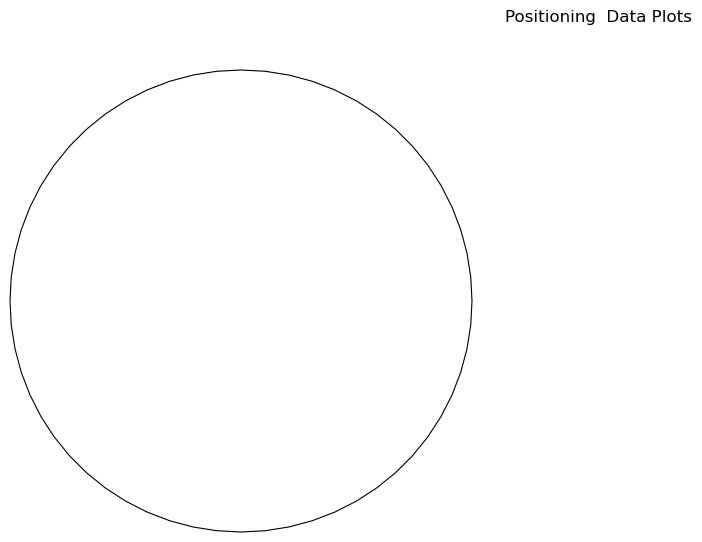

In [21]:
positions.draw()

Worked Example:

<img align="center" width="50%" style="padding-right:10px;" src="./Images/ortho.png">

___
## A6.4 Add Oceans, Land, a Graticule and, a Title
`Matplotlib` provides the `add_feature()` method for adding data of interest. `Cartopy` contains several commonly used data sets in a 'feature' library. Two of these data sets are `OCEANS` and `LAND`. The oceans will by default be colored blue and land will be colored yellow. You may draw the oceans to the subplot ax1 by adding the line  `ax1.add_feature(cartopy.feature.OCEAN)`. Also add the land (using `cartopy.feature.LAND`), but make sure that the edges of the land are drawn in black by adding the argument `edgecolor='black'` in your call to `add_feature`.

Now that the oceans and landmasses have been plotted you should overlay the subplot `ax1` with gridlines(). Use the `gridlines()` method for this purpose, using its default behavior i.e., do not provide any arguments:

    ax1.add_feature(cartopy.feature.OCEAN)
    ax1.add_feature(cartopy.feature.LAND, edgecolor='black')
    ax1.gridlines()
    ax1.set_title('Orthographic Map of Coverage Area')

Drawing Positioning Data


c:\Users\lalaf\miniconda3\envs\py39\lib\site-packages\cartopy\io\__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_ocean.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
c:\Users\lalaf\miniconda3\envs\py39\lib\site-packages\cartopy\io\__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


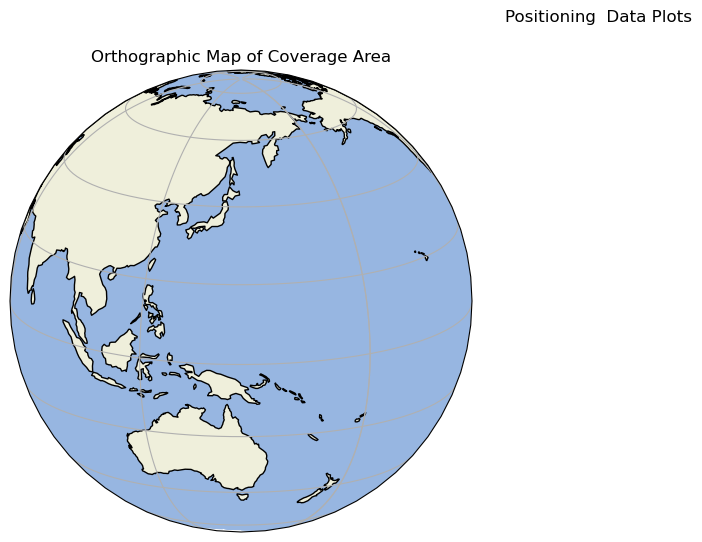

In [22]:
positions.draw()

Worked Example:

<img align="center" width="50%" style="padding-right:10px;" src="./Images/ortho_ocean_land.png">


___
## A6.5 Plot the central point  $(\varphi_{central},\lambda_{central})$

Finally! You are now ready to add some data specific to the survey to the map. We want to add a single round marker (`marker='o'`) of size 7 (` markersize=7.0`) that is black (`markerfacecolor='black'`) with an edge of width 2.5 (`markeredgewidth=2.5`) that is white (`markeredgecolor='white'`) to the plot. We want to achieve this by using the matplotlib method `plot()`. We want to plot the marker at the central point  $(\varphi_{central},\lambda_{central})$ of the survey using `central_lon` as the x-coordinate and `central_lat` as the y coordinate. Since these are given as geodetic coordinates we need to provide the `plot()` method with the CRS so that they may be transformed to Cartesian coordinates; this is achieved by adding the argument `transform=crs_ortho` i.e., `plt.plot(...,transform=crs_ortho)`:

    plt.plot(central_lon, central_lat, marker='o', markersize=7.0, markeredgewidth=2.5,
                 markerfacecolor='black', markeredgecolor='white',
                 transform=crs_ortho)


Drawing Positioning Data


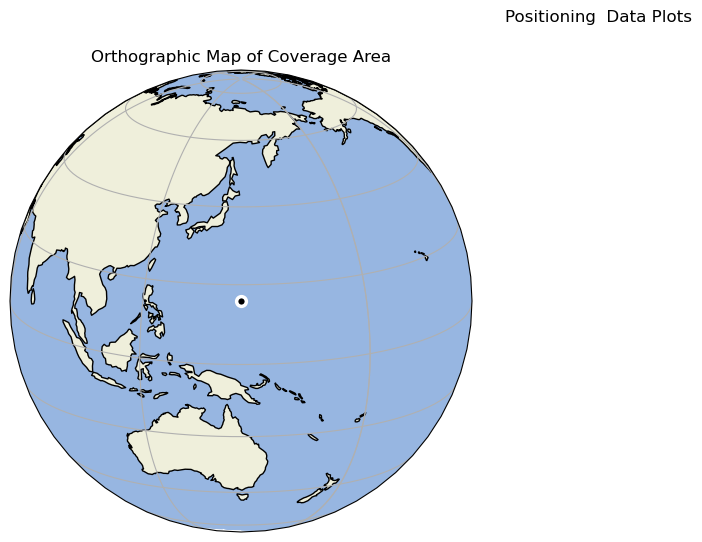

In [23]:
positions.draw()

Worked Example:

<img align="center" width="50%" style="padding-right:10px;" src="./Images/ortho_central.png">


___
## A6.6 Create a **UTM** Coordinate Reference System

The orthographic representation of the survey locale is useful to quickly inform the user where in the world a survey is located. However, when we want to treat the data in a more analytical way the distortion properties of the projection become of key importance. In the field of ocean mapping UTM projections are often used because they preserve any angle between arcs on the ellipsoid in the projection plane (UTM projections are **conformal**) and they distort distances relatively little if used appropriately. 

The reason that the coordinates are projected onto a UTM projection plane is generally not for visualization purposes, but rather to allow for geometric calculations using **isometric** Cartesian UTM coordinates rather than **curvilinear** geodetic coordinates i.e., we may use Pythogoras to calculate the distance between two points and use plane trigonometry to deal with angles and distances in triangles. If the UTM coordinates are used appropriately the distortions induced by using the transformed coordinates are relatively small. Although there certainly are other transformations available that would achieve the same, UTM projections are popular because they are widely supported by mapping software and well understood by mapping professionals.

$$zone_\lambda=floor \Bigg( \frac{\lambda+180}{6}modulo(60)+1 \Bigg) $$

UTM projections are used for latitudes from $80^\circ$ South to $84^\circ$ North. There are 120 UTM projections! There are these many to minimize the distortion in a UTM map for any region. There are 60 longitude **zones** $zone_\lambda$; each zone being $6^\circ$ of longitude wide. The longitude zones are numbered sequentially with zone 1 covering $-180^\circ$ to $-174^\circ$ E and zone 60 covering $174^\circ$ to $180^\circ$ E. Each longitude zone is then divided in a Southern ('S') and a Northern ('N') section with the equator being the boundary between the two. For example, the location of Portsmouth, NH is approximately 43° N, 70° W, which puts it in UTM zone 19N.

Geometric distortion increases rapidly for data outside a zone. It is therefore best-practice to ensure that data outside a zone are not projected using the projection parameters for that zone. However, know that this is routinely ignored for data at the edges of zones when they do not significantly exceed the zone boundaries.

We want to draw a map of the survey area using a UTM projection using the UTM zone containing  the central point  $(\varphi_{central},\lambda_{central})$. 

 - Add a local variable called `zone_number` and assign it the longitude zone number for `central_lon`. The modulo operator in the equation for $zone_\lambda$ given above ensures that the right zone is returned when longitudes in the Western Hemisphere are reported as positive numbers e.g.: $\lambda=-70==\lambda=290\Rightarrow zone_\lambda=19$:
 
        zone_number = int((np.floor((central_lon + 180) / 6) % 60) + 1)

 - Add a local variable `southern_hemisphere` and set its value to `True` if the central latitude is in the Southern hemisphere or false if it is on the Northern hemisphere:
 
         if central_lat < 0:
            southern_hemisphere = ...
         else:
            ... = ...
 
  - create crs_utm by calling ccrs.UTM(). The first argument to provide is `zone=zone_number` and the second argument is `southern_hemisphere=southern_hemisphere`:
  
          crs_utm = ccrs.UTM( zone=zone_number, southern_hemisphere=southern_hemisphere)

***
## A6.7 Plot the UTM map

You will now create the second map in the single row of two maps. The map on the right will be the UTM map. To place the map on the right create a subplot of name ax2 and provide the argument projection=crs_utm:

    ax2 = fig.add_subplot( 1, 2, 2, projection=crs_utm)
    e_buffer=(np.max(self.longitudes)-np.min(self.longitudes))/10
    n_buffer=(np.max(self.latitudes)-np.min(self.latitudes))/5
    ax2.set_extent((np.min(self.longitudes)-e_buffer, np.max(self.longitudes)+e_buffer, np.min(
        self.latitudes)-n_buffer, np.max(self.latitudes)+n_buffer), crs=crs_utm)

The above also makes sure that the full extent of the data is shown in the UTM by setting the extents of the plot axes of ax2 as shown above. The set_extent() method provided by matplotlib sets the axes to the limit given by the arguments provided to it. In this case we know the geodetic coordinates of the survey, so we want to use the extent of the longitudes to provide the x-axis limits and the extent of the latitudes to set the y-axis limits. The set_extent() method of the ax2 object then needs to be called with the arguments: $min(\lambda), max(\lambda), min(\varphi), min(\varphi)$ and crs=crs_utm. I have added some buffers making that all the positions are shown well within the plot boundaries.

Drawing Positioning Data


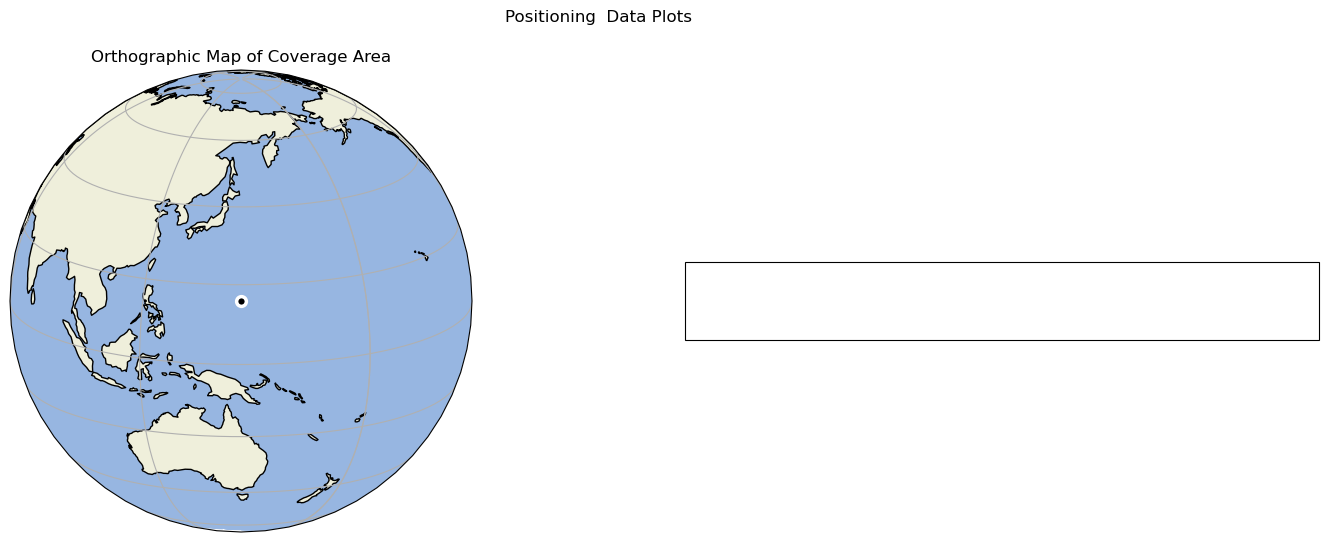

In [24]:
positions.draw()

Worked Example:

<img align="center" width="80%" style="padding-right:10px;" src="./Images/cart_utm1.png">


___
## A6.8 Add oceans, land,  graticule and Title

To make the UTM map on the right (`ax2`) appear similar to the Orthographic map on the left add the `OCEANS` and `LAND`. features in the same manner. Also overlay the subplot `ax2` with gridlines, And set the title to `'UTM Map of Positioning Data'`

Drawing Positioning Data


c:\Users\lalaf\miniconda3\envs\py39\lib\site-packages\cartopy\io\__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_ocean.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
c:\Users\lalaf\miniconda3\envs\py39\lib\site-packages\cartopy\io\__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


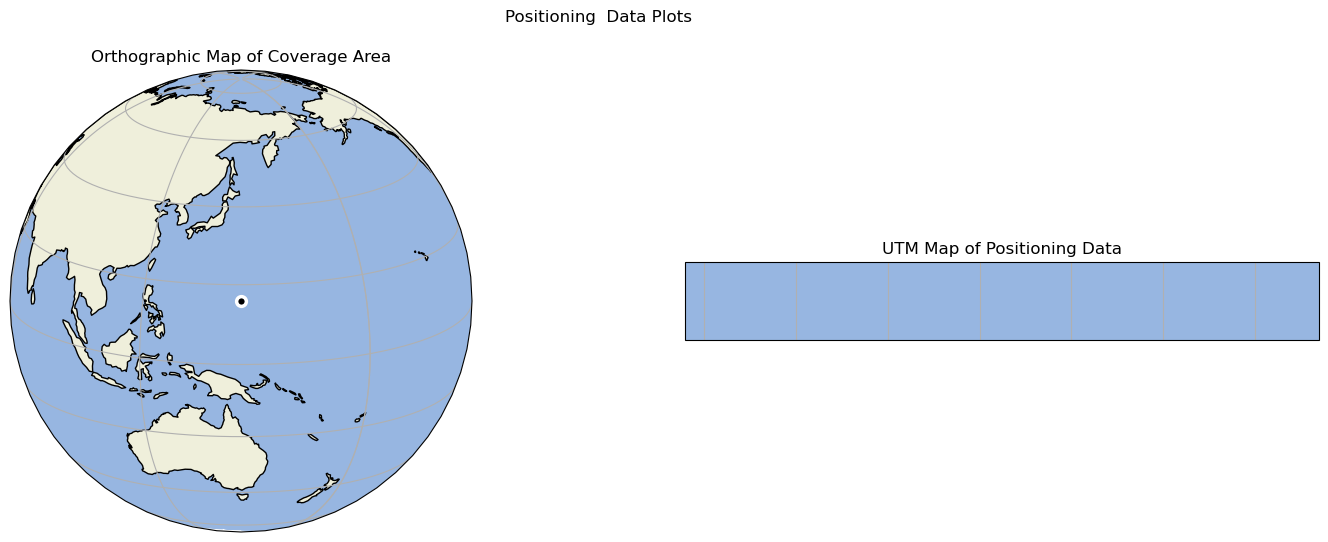

In [25]:
positions.draw()

Worked Example:

<img align="center" width="80%" style="padding-right:10px;" src="./Images/cart_utm2.png">


___

## A6.8.0 Plot the Positions

You are now ready to add the position data to the map. To iterate through all the coordinates contained in the object use the following for loop defined by `for lon, lat in zip(self.longitudes, self.latitudes):`. For each point we want to add a single point marker (`marker='.'`) of size 2 (` markersize=2.0`) that is black (`markerfacecolor='black'`) to the plot. You want to plot each set of coordinates  $(\varphi,\lambda)$ of the survey using `lon` as the x-coordinate and `lat` as the y coordinate. Since these are given as geodetic coordinates we need to provide the `plot()` method with the CRS so that they may be transformed to Cartesian coordinates; this is achieved by adding the argument `transform=crs_utm`.


        for lon, lat in zip(self.longitudes, self.latitudes):
            plt.plot(lon, lat, marker='.', markersize=...,
                     markerfacecolor='...', transform=...)

Drawing Positioning Data
55


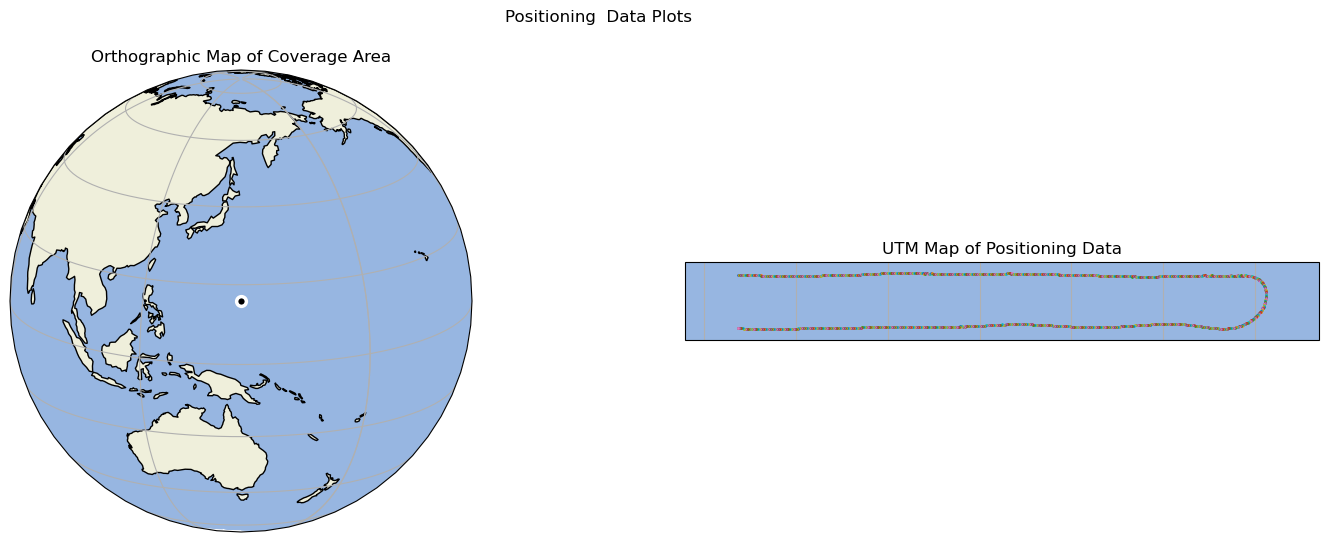

In [32]:
positions.draw()

Worked Example:

<img align="center" width="80%" style="padding-right:10px;" src="./Images/cart_utm3.png">


***
## A6.8.1 Discussion on Teams

On contribute to a discussion regarding map projections. Discuss the pros and cons of using UTM coordinates for the type of calculation done in this lab. In your discussion you could you comment on the appropriateness of UTM for the location, or you could address the distortions to content with e.g., the convergence of the UTM projections, propose the use of another projection, etc.


***
## A6.9 Projected coordinates

So-far we made use of the capability of matplotlib to plot data given a CRS, which is very convenient. However, it is also useful to perform calculations with projected coordinates. This is so common that we will add a `proj_pos` `numpy` array to the `Position` class to hold the projected coordinates and have the `proj_str` in the meta data represent the projection used to transform the geodetic coordinates to the projected coordinates. For now, `proj_str` should still be `Unknown`.

In [33]:
# positions
positions = Position()
positions.read_jhc_file(abs_path+'/Data/Lab_A_GNSS.txt')
print(positions.metadata["proj_str"])

Opening GNSS data file:d:\UNH\COURSES\INTEGRATED SEABED MAPPING\ESCI_872_Public/Data/Lab_A_GNSS.txt
None


Worked Example:

    Opening GNSS data file:/home/jupyter-semmed/ESCI_OE_874/Data/Lab_A_GNSS.txt
    None

***
### A6.9.0 Add a Projection Method

In your class definition add the method `carto_project()`. The method should take the arguments: `self`, `projection_name`, and `z_reference` representing the class object, the name of the projection, and the type of height coordinates respectively.

    def carto_project(self, projection_name, z_reference):

The `carto_project()` method will make use of the functionality of the `Proj` module. This module implements the transformation geospatial coordinates between `CRS`s and is used by the `cartopy` module that you have seen in the previous steps in this lab. For projecting data using [`PROJ`](https://proj.org/) we create a `proj` object that we then feed a string containing the properties of the projection that we want to use, e.g.:

    +proj=utm +zone=19 +north +ellps=WGS84 +datum=WGS84 +units=m +no_defs

As can be seen above we need to create a string that is descriptive of the projection. In the example the string sets the projection to a UTM projection for zone 19 North, using the WGS84 geodetic datum for both input in geodetic coordinates and output as UTM Eastings and Northings, and meters as the unit for the output coordinates.  

For now, we will keep the method really simple and just allow the use of the UTM projection and orthometric heights.

***
### A6.9.1 Test the Projection Name

        # Test whether projection_name is a string
        if not isinstance(projection_name, str):
            raise RuntimeError(
                'Position.project(): argument `projection` must be of type str')

In your `carto_project()`, add the lines given above the method definition. This will ensure that the argument `projection_name` is a string and that its contents, when converted to lower case, are `utm`. Later we can modify this method by adding other projections, but for now we will just implement the **UTM** projection.

***
### A6.9.2 Keep a List of Implemented Projections
       
        # Keep a list of projection that are implemented in this function
        implemented_projections = list()
        implemented_projections.append('utm')

This list keeps track of the projections that we have implemented; each time you implement a projection you may add to this list. Later we can modify this method by adding other projections, but for now we will just implement the **UTM** projection.

***
### A6.9.3 Test Whether the Projection Asked for is Implemented
       
        if projection_name.lower() not in implemented_projections:
            raise RuntimeError(
                'Position.project(): The projection `' + projection_name + '` is not yet implemented')

Test whether the projection asked for is implemented.

***
### A6.9.4 Ensure a Reference Ellipsoid is Defined

    if self.metadata["ellipsoid_name"] == None:
            raise RuntimeError(
                'Position.carto_project(): Requires ellipsoid metadata to be defined!')

We cannot project the data if we do not know to what geodetic datum the positioning data are referenced.

### A6.9.5 Create the Projection String
 
Test the `projection_name` if it is utm then start creating the string `proj_str` that instructs `Proj` how to project coordinates:

    if projection_name.lower() == 'utm':
        proj_str = '+proj=utm'

In [36]:
# positions
positions = Position()
positions.read_jhc_file(abs_path+'/Data/Lab_A_GNSS.txt')
positions.carto_project("UTM", "geoid")
print(positions.metadata["proj_str"])

Opening GNSS data file:d:\UNH\COURSES\INTEGRATED SEABED MAPPING\ESCI_872_Public/Data/Lab_A_GNSS.txt
+proj=utm


Worked Example:

    Opening GNSS data file:/home/jupyter-semmed/ESCI_OE_874/Data/Lab_A_GNSS.txt
    +proj=utm

***
### A6.9.6  Determine Central Latitude and Longitude 

Determine central latitude and longitude in a fashion similar to step A6.0 - make sure that it is given in degrees!

        central_lat = ...
        central_lon = ...


***
### A6.9.7  Determine The UTM Zone Number

Determine the UTM zone as described in step A6.6 and append the `proj_str` with the string  ' +zone=' and the string representing the zone number


In [41]:
# positions
positions = Position()
positions.read_jhc_file(abs_path+'/Data/Lab_A_GNSS.txt')
positions.carto_project("UTM", "geoid")
print(positions.metadata["proj_str"])

Opening GNSS data file:d:\UNH\COURSES\INTEGRATED SEABED MAPPING\ESCI_872_Public/Data/Lab_A_GNSS.txt
+proj=utm +zone=55


Worked Example:

    Opening GNSS data file:/home/jupyter-semmed/ESCI_OE_874/Data/Lab_A_GNSS.txt
    +proj=utm +zone=55

***
### A6.9.8  Determine the Hemisphere

Determine whether the central latitude is on the Northern or Southern hemisphere and append the `proj_str` with ' +north' or ' +south'.

            if central_lat > 0:
                proj_str += ' +north'
            else:
                ... += ...

In [42]:
# positions
positions = Position()
positions.read_jhc_file(abs_path+'/Data/Lab_A_GNSS.txt')
positions.carto_project("UTM", "geoid")
print(positions.metadata["proj_str"])

Opening GNSS data file:d:\UNH\COURSES\INTEGRATED SEABED MAPPING\ESCI_872_Public/Data/Lab_A_GNSS.txt
+proj=utm +zone=55 +north


Worked Example:

    Opening GNSS data file:/home/jupyter-semmed/ESCI_OE_874/Data/Lab_A_GNSS.txt
    +proj=utm +zone=55 +north

***
### A6.9.9 Set the Geodetic Datum for the input coordinates

Append the `proj_str` with the string ' +ellps=' and then the string contained in `self.metadata["ellipsoid_name"]`. *Note that if you do not have the right ellipsoid set in the meta data this is where things go wrong!*

    proj_str += ' +ellps=' + self.metadata["ellipsoid_name"]

In [43]:
# positions
positions = Position()
positions.read_jhc_file(abs_path+'/Data/Lab_A_GNSS.txt')
positions.carto_project("UTM", "geoid")
print(positions.metadata["proj_str"])

Opening GNSS data file:d:\UNH\COURSES\INTEGRATED SEABED MAPPING\ESCI_872_Public/Data/Lab_A_GNSS.txt
+proj=utm +zone=55 +north +ellps=WGS84


Worked Example:

    Opening GNSS data file:/home/jupyter-semmed/ESCI_OE_874/Data/Lab_A_GNSS.txt
    +proj=utm +zone=55 +north +ellps=WGS84

***
### A6.9.10 Set the Geodetic Datum for the output coordinates

Append the `proj_str` with the string ' +datum=' and then, just like in step A6.9.9, the string contained in `self.metadata["ellipsoid_name"]`. 

    proj_str += ' +datum=' + ...

<img align="left" width="6%" style="padding-right:10px;" src="./Images/key.png"> 
Note that if you want  to do a data transformation this will implement it! You may even transform between datums without projecting the data! This makes the `PROJ` library extremely powerful for geospatial work and explains its popularity

In [44]:
# positions
positions = Position()
positions.read_jhc_file(abs_path+'/Data/Lab_A_GNSS.txt')
positions.carto_project("UTM", "geoid")
print(positions.metadata["proj_str"])

Opening GNSS data file:d:\UNH\COURSES\INTEGRATED SEABED MAPPING\ESCI_872_Public/Data/Lab_A_GNSS.txt
+proj=utm +zone=55 +north +ellps=WGS84 +datum=WGS84


Worked Example:

    Opening GNSS data file:/home/jupyter-semmed/ESCI_OE_874/Data/Lab_A_GNSS.txt
    +proj=utm +zone=55 +north +ellps=WGS84 +datum=WGS84

***
### A6.9.11 Set the Units for the output coordinates

We want the output coordinates to be meters, thus append `proj_str` with the string ' +units=m'

In [ ]:
# positions
positions = Position()
positions.read_jhc_file(abs_path+'/Data/Lab_A_GNSS.txt')
positions.carto_project("UTM", "geoid")
print(positions.metadata["proj_str"])

Worked Example:
    
    Opening GNSS data file:/home/jupyter-semmed/ESCI_OE_874/Data/Lab_A_GNSS.txt
    +proj=utm +zone=55 +north +ellps=WGS84 +datum=WGS84 +units=m

***
### A6.9.12 Prevent Proj default behavior

Proj has a number of default behaviors that we do not want, to disable the default behavior add ' +no_defs' to 'proj_str'

In [46]:
# positions
positions = Position()
positions.read_jhc_file(abs_path+'/Data/Lab_A_GNSS.txt')
positions.carto_project("UTM", "geoid")
print(positions.metadata["proj_str"])

Opening GNSS data file:d:\UNH\COURSES\INTEGRATED SEABED MAPPING\ESCI_872_Public/Data/Lab_A_GNSS.txt
+proj=utm +zone=55 +north +ellps=WGS84 +datum=WGS84 +units=m +no_defs


Worked Example:

    Opening GNSS data file:/home/jupyter-semmed/ESCI_OE_874/Data/Lab_A_GNSS.txt
    +proj=utm +zone=55 +north +ellps=WGS84 +datum=WGS84 +units=m +no_defs

***
### A6.9.13 Create a Pyproj Object

To perform the projection, we will create an object `proj_obj` using the expression  `proj_obj = proj.Proj(proj_str)`. This object now has everything that is needed to perform the projection of our geographic coordinates to projected UTM coordinates.

    proj_obj = proj.Proj(proj_str)

***
### A6.9.14 Calculate the Easting and Northings

The coordinates in many projections including UTM are known as **Eastings and Northings**. Eastings are in the Eastward direction of the mapping plane whereas Northings are in the northward direction. Please realize that points with an equal Northing generally **do not** have the same latitude, and similarly points of equal Easting do not have the same longitude!

    E, N = proj_obj([l*180/pi for l in self.longitudes],[l*180/pi for l in self.latitudes])

***
### A6.9.15 Create a Matrix of Positions as 3D Column vectors

Though normally we would not keep multiple variables representing the same quantity in a class, sometimes we may make an exemption. This is an example of such a case. We want to preserve the raw data, whether they were supplied as projected coordinates or geodetic coordinates. We also often need both a projected and a geodetic representation of the positioning data. Typically, there are significant amounts of positioning data so that having to convert the data on the fly becomes a costly process in terms of CPU resources. Therefore it is worthwhile to maintain both, but this comes at the cost of increased memory usage and increased potential for error.


            if z_reference.lower()=='ortho' or z_reference.lower()=='geoid':
                self.proj_pos=np.asarray([np.asarray(E),np.asarray(N),np.asarray(self.heights)])
            else:
                raise RuntimeError(
                  'Position.carto_project(): currently only implemented for orthometric heights')


In [47]:
# positions
positions = Position()
positions.read_jhc_file(abs_path+'/Data/Lab_A_GNSS.txt')
positions.carto_project("UTM", "ortho")
print( positions.proj_pos.shape)
print( 'Eastings: ')
print( positions.proj_pos[0])
print( 'Northings: ')
print( positions.proj_pos[1])
print( 'Ortometric Heights: ')
print( positions.proj_pos[2])

Opening GNSS data file:d:\UNH\COURSES\INTEGRATED SEABED MAPPING\ESCI_872_Public/Data/Lab_A_GNSS.txt
(3, 1397)
Eastings: 
[392719.33677684 392724.82744976 392730.79148882 ... 392723.97575872
 392718.46095942 392713.02243242]
Northings: 
[1764811.7544494  1764811.99354627 1764812.29453314 ... 1764405.12548713
 1764405.23166895 1764405.39611966]
Ortometric Heights: 
[28.895 29.146 28.98  ... 28.846 28.776 82.375]


Worked Example:

    Opening GNSS data file:/home/jupyter-semmed/ESCI_OE_874/Data/Lab_A_GNSS.txt
    (3, 1397)
    Eastings: 
    [392719.33677684 392724.82744976 392730.79148882 ... 392723.97575872
     392718.46095942 392713.02243242]
    Northings: 
    [1764811.7544494  1764811.99354627 1764812.29453314 ... 1764405.12548713
     1764405.23166895 1764405.39611966]
    Ortometric Heights: 
    [28.895 29.146 28.98  ... 28.846 28.776 82.375]



***
### A6.9.16 Discussion on Teams

On [Teams](https://teams.microsoft.com/l/message/19:4f2938a578d745619a874214b3506932@thread.tacv2/1634679721760?tenantId=d6241893-512d-46dc-8d2b-be47e25f5666&groupId=b7209537-725b-40fc-bdbe-212e9689ef18&parentMessageId=1634679721760&teamName=ESCI%20OE%20874&channelName=Lab%20A&createdTime=1634679721760) create or contribute to a discussion regarding the handedness of UTM coordinates and geodetic coordinates, how they relate to heading, and what the significance of the choice of depths being represented by positive or negative values is. 



***
# A7 Echosounder Data

So far, we have treated all the data collected by what we normally call **ancillary systems**. We have not discussed the data provided by our sonar system yet. In this case the data is singlebeam echosounder data and contained in the file 
`Lab_A_TWTT.txt`

If you open that file, you will see that the data appears thus:

    2011 128 3 49 10.57 1304826550.57 0.121093
    2011 128 3 49 10.57 1304826550.57 0.120892
    2011 128 3 49 10.91 1304826550.91 0.121127
    2011 128 3 49 10.92 1304826550.92 0.121143
    2011 128 3 49 11.27 1304826551.27 0.121443
    2011 128 3 49 11.27 1304826551.27 0.121441
    2011 128 3 49 11.62 1304826551.62 0.121551
    2011 128 3 49 11.62 1304826551.62 0.121521
    2011 128 3 49 11.97 1304826551.97 0.121493
    
The data is similar in structure to the data provided in the other files. What we are interested in is the 6th column, which is the POSIX time of transmit, and the 7th column, which represents the **<ins>T</ins>wo <ins>W</ins>ay <ins>Travel</ins> <ins>Time</ins>** (**TWTT**); the time that it took for a sound signal to travel from the transmit transducer to the seafloor and back to the receive transducer.

You are given the `TWTT` class and may find in the file `twtt.py` in your mycode folder. Have a look at it, it should look very familiar.

Opening Two Way Travel Time (TWTT) data file:d:\UNH\COURSES\INTEGRATED SEABED MAPPING\ESCI_872_Public/Data/Lab_A_TWTT.txt
Drawing TWTT Data


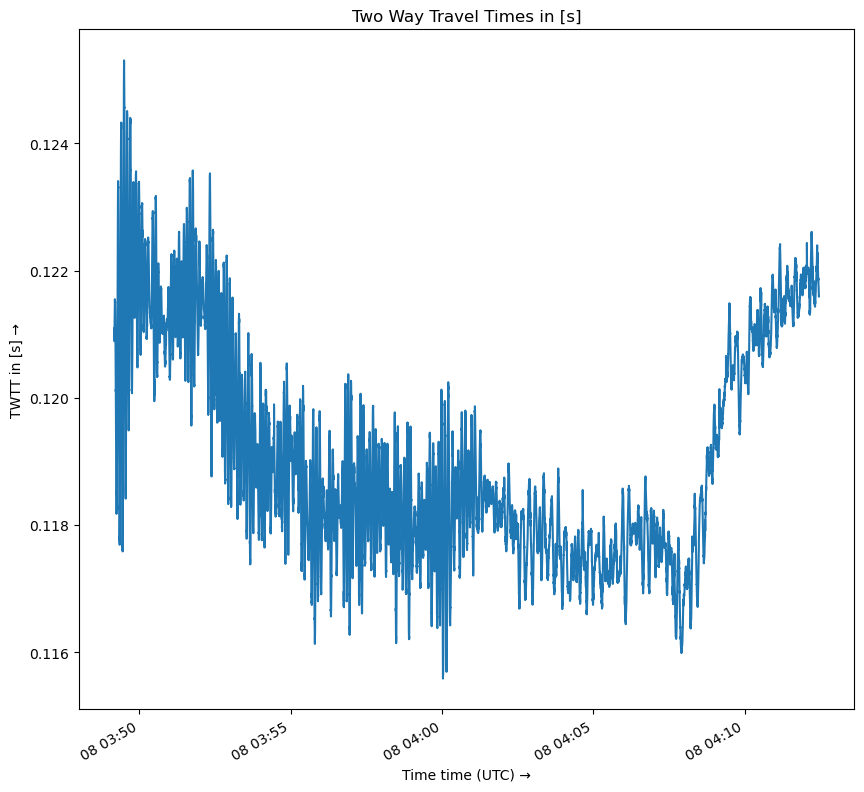

In [48]:
twtts=TWTT()
twtts.read_jhc_file(abs_path+'/Data/Lab_A_TWTT.txt')
twtts.draw()

***
## 7.1 Interpreting the TWTT Data

Looking at the plot you will notice that the data shows a trend with, what appears to be, a lot of noise superimposed. This makes sense as the TWTT is a proxy to the distance from the sonar transducer to the sea floor. That distance is affected by location and motion of the vessel, as well as the water level and sound speed. If we observe those factors systematically affecting the observations, we can correct for them and remove the majority of the apparent noise.

You will extensively discuss the effects of sound speed in the rest of the term, at this time we will simply assume that the speed of sound is a constant and is $1500 m/s$. Thus, observed depths may simply be determined by:

$$D_{obs} = \frac{c\cdot TWTT}{2}$$

where:
$c:$ celerity of sound ($1500 m/s$)

The rest of this lab will then be focusing on removing the apparent noise from the depth observations.

***
# A8 Integrating the Data

So far, we have treated all collected data separate. In this step you will combine the sensor data to create an integrated depth solution. That is, we combine the two-way travel times together with all the data required to transform it into a depth relative to the chart datum. We already have the means of importing and handling all the data streams, but we do not yet have a mechanism to integrate them. For the integration we will need to know where the sensors are in relation to each other, which we will handle through the Vessel class, and we also will need to combine the observations, which we will handle through an Integration class that we will create.

Here you will navigate the transmitter and receiver of a multibeam for the case of a (near) vertically oriented beam. This special case may be treated as a (narrow beam) single beam echo sounder through ignoring the array-relative angles of transmission and reception.

The integration consists of determining the positions of the transducers at both transmit and reception time, and then finding the location of the seafloor relative to it. This implies that we need to have a mechanism of determining all the sensor values at transmit and receipt time, but since the sensors are asynchronous it is unlikely that there are data at these exact epochs. Thus, we first need to interpolate the various data. We also need to determine the position of the sensors at the time of transmit and receipt with respect to each other, which implies that we must do a transformation of the Vessel lever arms and transform them to geo-referenced coordinates. Finally, you will need to transform the TWTT to a distance and offset this from the position of the transducers to determine the depth, which means that there needs to be a method of transforming TWTT to distance.

***
## A8.1 Implementing A Ship's Reference Frame 

<br><br><img align="center" width="60%" style="padding-right:10px;" src="./Images/usns_henson.png"><br><br>

The sensors acquiring the three sets of observations (sonar-relative range, position, and orientation) are not co-located. Thus, you must allow for the lever arms between the sensors. For example, here the relative Ship's Reference Frame (SRF) offsets of the transmitter, receiver and GNSS antenna are provided.

For this lab we will also assume that the orientation time series represents the SRF (thus ignoring the fact that the MRU may be misaligned with respect to the SRF), and that the heave solution is provided for the Reference Position (RP). 

<br><br><img align="center" width="60%" style="padding-right:10px;" src="./Images/trajectories.png"><br><br>

The only constraining factor between the locations of the four sensors (Transmit Transducer **Tx**, Receive Transducer **Rc**,Antenna, and Motion Reference Unit **MRU**) is that their relative locations within the SRF remain constant i.e.. the SRF is rigid. This will be used to predict their independent trajectories as the vessel rotates (yaws and/or pitches and/or rolls) during data acquisition. The transformations involved are known as rigid body transformations. The previously defined `Vessel` class creates a way we may implement a coordinate reference system.

The figure below shows the meta data and the lever arms for the USNS Henson. In the code cells below, you will implement the ship's reference frame. Note that the MRU is located at the RP.

<br>
<img align="left" width=".40%" style="padding-right:10px;" src="./Images/vessel.png">
<img align="left" width="30%" style="padding-right:10px;" src="./Images/lever_arms.png">
<br><br>


Let us start by defining the vessel:

In [50]:
# We also need a Vessel class object to store the metadata and geometric data descriptive of the vessel

vessel = Vessel()

# The transmit transducer
vessel.lever_arm_trans = np.array([16.26, -1.75,   4.15]).reshape((3, 1))

vessel.wl = -2.59

vessel.metadata["name"]="USNS Henson"
vessel.metadata["owned_by"]="United States Navy"
vessel.metadata["operated_by"]="United States Navy"
vessel.metadata["pos_source"]="NavCom (C-Nav)"
vessel.metadata["sonar"]="Kongsberg EM710"
vessel.metadata["mru"]="Applanix POS/MV 320"
vessel.metadata["loa"]=100

print(vessel)

Vessel Metadata: name: USNS Henson
owned_by: United States Navy
operated_by: United States Navy
loa: 100
pos_source: NavCom (C-Nav)
sonar: Kongsberg EM710
mru: Applanix POS/MV 320
dist_unit: m
angle_unit: rad



Worked Example:

    Vessel Metadata: name: USNS Henson
    owned_by: United States Navy
    operated_by: United States Navy
    loa: 100
    pos_source: NavCom (C-Nav)
    sonar: Kongsberg EM710
    mru: Applanix POS/MV 320
    dist_unit: m
    angle_unit: rad


In the code cell above all the metadata is defined and the lever arm `lever_arm_trans` to the transmit transducer is defined as $16.26 m$ forward of the RP, $1.75 m$ to port of the RP, and $4.15 m$ down of the RP i.e., `lever_arm_trans` = $[16.26, -1.75, 4.15]^T$.

In the code cell below also define the `lever_arm_rec` to the receive transducer as $[14.82, -2.01,   4.17]^T$, the `lever_arm_pos` to the GNSS antenna as $[-5.73, -0.12, -30.00]^T$ and finally  the `lever_arm_mru` to the IMU as $[0, 0, 0]^T$.

***
## A8.2 Integration

There are many ways we could implement the integration step of the data. In our case we will create a class called Integration. This class will hold the locations of all the sensors as lever arms relative to the RP in a georeferenced data frame, as well as the locations of all the sensors and the depth associated to each ping. 

In this section we will be creating the constructor method for the `Integration` class, that is, all your editing will be in the `__init__` method of class `Integration`. All the steps below are in sequence.

    # A8.2 Integration
    class Integration:
        """A Class for Integrating Data to Create Soundings"""

        def __init__(self, twtt, pos, motions, sound_speed_profile, water_levels, vessel):
            pass # Remove this once underway


In [52]:
# The transmit transducer
vessel.lever_arm_trans = np.array([16.26, -1.75,   4.15]).reshape((3, 1))

# The transmit transducer
vessel.lever_arm_rec = np.array([14.82, -2.01,   4.17]).reshape((3, 1))

#The Positioning System
vessel.lever_arm_pos = np.array([-5.73, -0.12, -30.00]).reshape((3, 1))

# The Motion Reference Unit
vessel.lever_arm_mru = np.array([0, 0, 0]).reshape((3, 1))
vessel.wl = -2.59

In [56]:
# Get the data path
abs_path = os.path.abspath(os.path.curdir)

# TWTTs
twtt = TWTT()
twtt.read_jhc_file(abs_path+'/Data/Lab_A_TWTT.txt')

# positions
pos = Position()
pos.read_jhc_file(abs_path+'/Data/Lab_A_GNSS.txt')
# make sure that there is Cartesian representation of the positions
pos.carto_project('utm','ortho')

# Motion data
motions = Motion()
motions.read_jhc_file(abs_path+'/Data/Lab_A_MRU.txt')

# Water level data
water_levels = WaterLevel()
water_levels.read_jhc_file(abs_path+'/Data/Lab_A_TIDE.txt')

# Sound speed data
sound_speed_profile = [1500]  # Just a single sound speed

integration=Integration(twtt, pos, motions, sound_speed_profile, water_levels, vessel)
print(integration)

Opening Two Way Travel Time (TWTT) data file:d:\UNH\COURSES\INTEGRATED SEABED MAPPING\ESCI_872_Public/Data/Lab_A_TWTT.txt
Opening GNSS data file:d:\UNH\COURSES\INTEGRATED SEABED MAPPING\ESCI_872_Public/Data/Lab_A_GNSS.txt
Opening motion data file:d:\UNH\COURSES\INTEGRATED SEABED MAPPING\ESCI_872_Public/Data/Lab_A_MRU.txt
Opening water level data file:d:\UNH\COURSES\INTEGRATED SEABED MAPPING\ESCI_872_Public/Data/Lab_A_TIDE.txt


Worked Example:

    Opening Two Way Travel Time (TWTT) data file:/home/jupyter-semmed/ESCI_OE_874/Data/Lab_A_TWTT.txt
    Opening GNSS data file:/home/jupyter-semmed/ESCI_OE_874/Data/Lab_A_GNSS.txt
    Opening motion data file:/home/jupyter-semmed/ESCI_OE_874/Data/Lab_A_MRU.txt
    Opening water level data file:/home/jupyter-semmed/ESCI_OE_874/Data/Lab_A_TIDE.txt
    <mycode.integration.Integration object at ...>

***
### A8.2.0 Data for integration

For each ping we need to know the sound speed profile, the transmit time, the vessel reference frame, the TWTT, the orientation at transmit and reception time. Only some of these data are known at the appropriate times, namely the data stored in the `twtt`, and `vessel` objects. All others will need to be resampled to get appropriate values at both transmit and receive time.

The first step is then to preserve the `twtt`, and `vessel` data by assigning them to variables of the same name in the `Integration` constructor i.e., *self.twtt = twtt* etc. Do this for all three of these objects.

        self.pos = pos
        self.vessel = vessel
        self.twtt = twtt
        self.ssp = sound_speed_profile
        
Note that we will work with Cartesian coordinates for now - so we will be accessing the projected positions in the object `pos` of class `Position`.

Note that the behavior of the classes is preserved e.g., the call to `print(pos)` and `print(integration.pos)`  should have the exact same results:

In [57]:
print(integration.pos)

geodetic_units: rad
height_units: m
proj_units: m
geoid_name: EGM08
ellipsoid_name: WGS84
height_relative_to: geoid
time_basis: UTC
proj_str: +proj=utm +zone=55 +north +ellps=WGS84 +datum=WGS84 +units=m +no_defs
Minimum latitude       : 0.278496
Maximum latitude       : 0.278564
Minimum longitude      : 2.548137
Maximum longitude      : 2.548780
Minimum height         : 27.18m
Maximum height         : 82.38m
Start Time             : 2011-05-08 03:49:11+00:00
End Time               : 2011-05-08 04:12:27+00:00



Worked Example:

    geodetic_units: rad
    height_units: m
    proj_units: m
    geoid_name: EGM08
    ellipsoid_name: WGS84
    height_relative_to: geoid
    time_basis: UTC
    proj_str: +proj=utm +zone=55 +north +ellps=WGS84 +datum=WGS84 +units=m +no_defs
    Minimum latitude       : 0.278496
    Maximum latitude       : 0.278564
    Minimum longitude      : 2.548137
    Maximum longitude      : 2.548780
    Minimum height         : 0.47m
    Maximum height         : 1.44m
    Start Time             : 2011-05-08 03:49:11+00:00
    End Time               : 2011-05-08 03:49:11+00:00



***
### A8.2.1 Determine the number of pings

Memory allocation is an expensive process in terms of computing time. Since we know how many data records there will be, namely the number of TWTTs, we can allocate all the memory in one step, which is much more efficient than allocating memory for each additional TWTT as we cycle through them. Thus our next action should be to determine how many TWTTs there are. Assign this value to `n_twtt_times`:

    n_twtt_times = len(twtt.times)

***
### A8.2.2 Memory Allocation

We will start by allocating memory for a number of variables. We will create two lists:

        R_tx: List of rotation matrices orienting the VRF reference frame wrt 
              the geodetic reference frame at transmit
        R_rx: List of rotation matrices orienting the VRF reference frame wrt 
              the geodetic reference frame at reception
        
We will also create a number of `np.zeros` matrices of dimension 3x`n_twtt_times`:

        self.lever_arm_pos_tx:   The position lever arms wrt the geodetic reference frame at transmit
        self.lever_arm_pos_rx:   The position lever arms wrt the geodetic reference frame at reception
        self.lever_arm_trans_tx: The transducer lever arms wrt the geodetic reference frame at transmit
        self.lever_arm_rec_rx:   The transducer lever arms wrt the geodetic reference frame at reception
        self.pos_rp_tx:          The RP lever arms wrt the geodetic reference frame at transmit
        self.pos_rp_rx:          The RP lever arms wrt the geodetic reference frame at reception
        self.pos_trans_tx:       The transmit transducer lever arms wrt the geodetic reference frame at transmit
        self.pos_rec_rx:         The receive transducer lever arms wrt the geodetic reference frame at reception
        
Implement this through:

    R_tx = list()
    R_rx = ...
    self.lever_arm_pos_tx=np.zeros([3,n_twtt_times])
    self.lever_arm_pos_rx=...
    self.lever_arm_trans_tx=...
    self.lever_arm_rec_rx=...
    self.pos_rp_tx=...
    self.pos_rp_rx=...
    self.pos_trans_tx=...
    self.pos_rec_rx=...

***
### A8.2.3 Converting the `datetime` objects to POSIX Times

For handling the time series contained in the various data objects it will be useful if we use **POSIX** time. For example we want to create a variable `t_twtt` that is an np.array of length `n_twtt_times`. You may achieve this through the statement:

        t_twtt = np.array([e.timestamp() for e in twtt.times])
        
Similarly create the following np.arrays

        t_pos: POSIX times for the positions
        t_mru: POSIX times for the motions
        t_wl:  POSIX times for the water levels
        
Code for this step:

    t_twtt = np.array([e.timestamp() for e in twtt.times])
    t_pos = np.array([e.timestamp() for e in ...])
    t_mru = ...
    t_wl = ...

***
### A8.2.4 Resampling the Data

<br><br><img align="center" width="60%" style="padding-right:10px;" src="./Images/asynchronous.png"><br><br>

We will resample the data from the sensors so that we will have interpolated observations for the transmit and reception times associated to the TWTTs. We will do this first for the transmit times and then for the reception times using the POSIX time determined in step 8.2.3.


***
#### A8.2.4.0 Transmit event interpolation

We may use the `numpy.interp()` method for most of our data e.g., to determine the pitch at the time of transmit we may use:

        self.p_tx = np.interp(t_twtt, t_mru, motions.pitch)
        
The result of this is that the pitch motions observed at `t_mru` are linearly interpolated to get results at the transmit times `t_twtt`.

Similarly create the following time series

        self.p_tx:  For the pitch motions
        self.r_tx:  For the roll motions
        self.y_tx:  For the yaw motions
        self.h_tx:  For the heave motions
        self.wl_tx: For the water level data
        
The positions are a little more complicated as they are 3 dimensional. Fortunately, the `SciPY` package provides a convenient method for doing this in a two-step process. From the SciPy documentation for the `interp1d` method: 

        "x and y are arrays of values used to approximate some function f: y = f(x). This class returns a function whose call method uses interpolation to find the value of new points."
        
That is `interp1d` takes one- or multi-dimensional series data and returns a function that may be used to interpolate, or even extrapolate, a value. You may implement this as follows:

        f=interp1d(t_pos,pos.proj_pos,bounds_error=False)
        self.pos_proj_ant_tx=f(t_twtt)
        
Look up the documentation to understand the `bounds_error=False` part of the call to `interp1d`. On [Teams](https://teams.microsoft.com/l/message/19:4f2938a578d745619a874214b3506932@thread.tacv2/1634687400480?tenantId=d6241893-512d-46dc-8d2b-be47e25f5666&groupId=b7209537-725b-40fc-bdbe-212e9689ef18&parentMessageId=1634687400480&teamName=ESCI%20OE%20874&channelName=Lab%20A&createdTime=1634687400480) discuss why I may have included this.

Code for this step:

    self.p_tx = np.interp(t_twtt, t_mru, motions.pitch)
    self.r_tx = np.interp(t_twtt, t_mru, ...)
    self.y_tx = np.interp(t_twtt, ..., ...)
    self.h_tx = np.interp(..., ..., ...)
    self.wl_tx = np.interp(t_twtt, t_wl, water_levels.water_levels)

    # Determine the interpolation function for the positions
    f=interp1d(t_pos,pos.proj_pos,bounds_error=False)
    self.pos_proj_ant_tx=f(t_twtt)


In [66]:
integration=Integration(twtt, pos, motions, sound_speed_profile, water_levels, vessel)
print(integration.p_tx)
print(integration.r_tx)
print(integration.y_tx)
print(integration.h_tx)
print(integration.wl_tx)
print(integration.pos_proj_ant_tx)

[ 0.02094395  0.02094395  0.02495821 ... -0.00279253 -0.00261799
 -0.00261799]
[0.         0.         0.0005236  ... 0.01727876 0.01623156 0.01623156]
[1.47253429 1.47253429 1.47253429 ... 4.83299123 4.83299123 4.83299123]
[-0.16 -0.16 -0.31 ... -0.01  0.02  0.02]
[0.35307944 0.35307944 0.35306056 ... 0.29625778 0.29624806 0.29624806]
[[           nan            nan            nan ... 3.92714545e+05
             nan            nan]
 [           nan            nan            nan ... 1.76440535e+06
             nan            nan]
 [           nan            nan            nan ... 6.73672815e+01
             nan            nan]]


***
#### A8.2.4.1  Receive time determination

We will use the same variable `t_twtt` to indicate the times of reception, these may then simply be determined by the sum of the transmission times and the two-way travel time i.e.:

    t_twtt += twtt.twtts

***
#### A8.2.4.2 Receive Event interpolation

Use the same approach as in A8.2.4.0 to determine the following time series:

    self.p_rx = np.interp(t_twtt, t_mru, motions.pitch)
    self.r_rx = ...
    self.y_rx = ...
    self.h_rx = ...
    self.wl_rx = ...
    
Also determine the interpolated positions; should you recreate an interpolation function?

    self.pos_proj_ant_rx=...

In [76]:
integration=Integration(twtt, pos, motions, sound_speed_profile, water_levels, vessel)
print(integration.p_rx)
print(integration.pos_proj_ant_rx)

[ 0.02251475  0.02251286  0.0261647  ... -0.00279253 -0.00261799
 -0.00261799]
[[           nan            nan 3.92719508e+05 ... 3.92713884e+05
             nan            nan]
 [           nan            nan 1.76481176e+06 ... 1.76440537e+06
             nan            nan]
 [           nan            nan 2.89028129e+01 ... 7.38872282e+01
             nan            nan]]
>>><<<
[[           nan            nan            nan ... 3.92714545e+05
             nan            nan]
 [           nan            nan            nan ... 1.76440535e+06
             nan            nan]
 [           nan            nan            nan ... 6.73672815e+01
             nan            nan]]


***
### A8.2.5  Allocating Memory for Processed Data

We know have re-sampled all the input data that we need at the epochs required to determine depths. We however have not yet allocated memory to store those depths, nor for the positions at which they are obtained.  We will create an `np.zeros` array `self.depth` of a size that allows the entry of a depth for each TWTT.

We also want to associate a position to each of these depths. If you think about it, this it is a somewhat problematic issue, as the transducer arrays are not co-located and move between transmit and reception. We will discuss the approach taken later, but at this time need to allocate a 3x`n_twtt_times` array to hold each position as a column vector, we will name this array `virtual_txrx` indicating that we will have a virtual array associated to the depth observations.

Finally, we want a set of soundings, which are the depths referenced to our datum, in this case orthometric depths, create an `np.zeros` array `self.soundings` of the same size as `self.depth`.

    self.depth = np.zeros((n_twtt_times))
    self.sounding = np.zeros((n_twtt_times))
    self.virtual_txrx = np.zeros((3,n_twtt_times))

In [88]:
integration=Integration(twtt, pos, motions, sound_speed_profile, water_levels, vessel)
print('Depths:    ' + str(integration.depth))
print('Soundings: ' + str(integration.sounding))
print('Tx_Rx Positions: ')
print(integration.virtual_txrx)

Depths:    [0. 0. 0. ... 0. 0. 0.]
Soundings: [0. 0. 0. ... 0. 0. 0.]
Tx_Rx Positions: 
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


    Depths:    [0. 0. 0. ... 0. 0. 0.]
    Soundings: [0. 0. 0. ... 0. 0. 0.]
    Tx_Rx Positions: 
    [[0. 0. 0. ... 0. 0. 0.]
     [0. 0. 0. ... 0. 0. 0.]
     [0. 0. 0. ... 0. 0. 0.]]

***
### A8.2.6  Looping through the TWTTs

You want to determine a depth for each time t in `twtt` create a for loop that cycles through the array `t_twtt`. Also keep count of the number of pings that we have processed. That is the first iteration through the loop the variable `ping` should have the value 0, the second time 1, etc. You will use this variable `ping` for indexing the arrays.

    ping = 0
    for t in t_twtt:

***
### A8.2.7 Calculate the Eucliden Euler Angle Rotation Matrices

<br><br><img align="center" width="60%" style="padding-right:10px;" src="./Images/rot_seq.png"><br><br>
        
Angles such as we have been using are known as **Euler** angles, they describe the rotation of a rigid body with respect to a reference frame. In our case they describe the roll, pitch and yaw angle of the vessel with respect to an inertial reference frame. 

If a triplet of rotation angles is provided, the resulting rigid body orientation can be calculated through the ordered series of steps outlined in the image above. Note that in this case each rotation is about the specific axis, AFTER it has been rotated because of previous rotations about the other axis - such sequences are properly known as asymmetric intrinsic rotations, and commonly referred to as **Tait Bryan** or **Cardan angles**.

<br><br><img align="center" width="60%" style="padding-right:10px;" src="./Images/head_rot.png"><br><br>

To introduce the concept of rigid body, rotations, let us consider just a rotation in heading. At the top of the mast, you have a GNSS fix at a specific epoch (a moment in time). Relative to that location, where is the sensor that you are trying to navigate? You need to know the offset in the Ship’s Reference Frame (SRF) between the Antenna and the Sensor (often a sonar). As we are ignoring roll and pitch, we assume the vessel is level. Thus, we need to know just the X-axis (aft-fore, or along ship) and Y-axis (athwartships) offsets between the two. In this case the sensor is forward (+ve-X) and to starboard (+ve-Y). Using the heading of the SRF (the bearing of the X-axis relative to north) at the time of the position epoch, we can now rotate this lever arm, which is a two-dimensional vector, around the Z-axis. What is the distance in meters to the North and meters to the East of the sensor relative to the antenna?

<br><br><img align="center" width="60%" style="padding-right:10px;" src="./Images/head_rot_calc.png"><br><br>

To do the calculation for a 2D vector, you can isolate the rotation of the two orthogonal offsets along each axis. Considering, just the SRF X and Y offsets in turn, you can calculate the resultant new X and Y offsets that are caused by the rotation (just a cosine and a sine).

The final vector is the sum of the two rotated orthogonal vectors. This can be expressed in a pair of equations, or equivalently as a matrix multiplication. The only difference between a 2D vector rotation and a 3D vector rotation is that the matrixes are 3x3 rather than 2x2. In this case you have to proceed with this same rotation logic, but sequentially around the three axes.

Extreme care must be taken to correctly interpret the rotation order. This is represented by the order in which the matrices are multiplied. Note, matrix multiplication is not commutative!

<br><br><img align="center" width="60%" style="padding-right:10px;" src="./Images/rotated_lever_arms.png"><br><br>

In the figure above the logic is take to the three-dimensional space in which we are working. 

$$ R_1(R)=\left[ {\begin{array}{cc}1 & 0 & 0\\0 & cos(R) & -sin(R)\\0 & sin(R) & cos(R)\\\end{array} } \right]$$

$$ R_2(P)=\left[ {\begin{array}{cc}cos(P) & 0 & sin(P)\\0 & 1 & 0\\-sin(P) & 0 & cos(P)\\\end{array} } \right]$$

$$ R_3(Y)=\left[ {\begin{array}{cc}cos(Y) & -sin(Y) & 0\\sin(Y) & cos(Y) & 0\\0 & 0 & 1\\\end{array} } \right]$$

where 
$R$: Roll    $P$: Pitch    $Y$: Yaw

Since matrix multiplication is not commutative:

$$ R_1\cdot R_2\cdot R_3\neq R_3\cdot R_2\cdot R_1 $$

Three elementary rotations can be applied, one with respect to each of the three axes. Compound rotations consist of a sequence of these elementary rotations, performed in a specified order. For example, the standard used here assumes an order of rotation which, when described **Extrinsically**:

    Axes do not move with each rotation, the first is first about the X, then the Y , and finally the Z axes.

The same transformation can equivalently be described **intrinsically**:

    Axes move with each rotation. whereby the first rotation is performed with respect to Z axis of the original system, the second rotation with respect to the Y axis of the transformed system and the third rotation with respect to the X axis of the doubly transformed system.

In our case the roll, pitch and yaw angles are provided so that to rotate a ship's lever arm to the geodetic reference frame you need to intrinsically rotate in the order Roll, then Pitch, then Yaw. In terms of linear algebra that is the rotation matrix *R* is determined as follows:

$$ R=R(Y)\cdot R(P)\cdot R(R)$$


In the code add the following for the rotation matrix `Rx_tx` at the current transmit event `ping`:

            Rx_tx = np.array([[1, 0,                     0                   ],
                              [0, cos(self.r_tx[ping]), -sin(self.r_tx[ping])],
                              [0, sin(self.r_tx[ping]),  cos(self.r_tx[ping])]])

Do the same for the yaw and pitch rotations (the variables should be `Ry_tx` and `Rz_tx` - it is up to you to decide whether `Ry_tx` should go along with the pitch or the yaw. Remember that the VRF X-axis is positive forward, Y-axis positive Starboard and, the Z-axis is positive downward.
    

***
### A8.2.8 Compound Rotation Matrix at Transmit

The total rotation for this ping can then be determined by the product of the 3 rotation matrices: 
Remember that the matrix multiplication is non commutative and goes in order from left to right i.e.: the statement

     R_tx.append( R_3@R_2@R_1)
     
Appends the Rotation matrix `R_3@R_2@R_1` to the list `R_tx`. that is to see `R_tx` applies an intrinsic rotation in the order `R_1`, then `R_2` and finally, `R_3`

Add the line above to the code, replacing `R_1`, `R_2` and `R_3` with the appropriate rotation matrices derived in  A8.2.7
                
The `@` symbol is the numpy operator for matrix multiplication. That is we add the total rotation matrix for TWTT `ping` to the list of transmit time rotation matrices.


***
### A8.2.9 Euler Angle Rotation Matrices at Reception

In similar fashion to A8.2.7 and A8.2.8 create the matrices `Rx_rx`, `Ry_rx` and `Rz_rx` for the orientation at time of reception. Add the total rotation to the list `R_rx`

***
### A8.2.10 Calculate the geo-referenced lever arms at Transmit

We need to know where the transmit transducer was with reference to the positioning system in a georeferenced frame at the time of transmit. 

$$\overrightarrow{\text{la}}_{geo} = R\cdot\overrightarrow{\text{la}}_{vrf}$$

where:<br>
$\overrightarrow{\text{la}}_{geo}$: Lever arm in geo-referenced space<br>
$\overrightarrow{\text{la}}_{vrf}$: Lever arm in the VRF

Since we know the lever arm `vessel.lever_arm_pos` of the positioning system and, `vessel.lever_arm_trans` of the transmit transducer we can determine the offsets in a georeferenced frame at the **time of transmit** if we apply the rotations. To rotate the positioning system lever arm at the time of transmit we need to use the `R_Tx[ping]` matrix i.e., the total rotation for the current ping.

    self.lever_arm_pos_tx[:,[ping]]=R_tx[ping]@vessel.lever_arm_pos
            
Determine the rotated lever arm for the transducer at the transmit time in similar manner and assign it to `self.lever_arm_trans_tx[:,[ping]]`

    self.lever_arm_trans_tx[:,[ping]] = ...

***
### A8.2.11 Calculate the geo-referenced lever arms at Reception

We also need to know where the receive transducer was with reference to the positioning system in a geo-referenced frame at the **time of reception**. Since we know the lever arm `vessel.lever_arm_pos` of the positioning system and `vessel.lever_arm_rec` of the receive transducer we can determine the offsets in a geo-referenced frame in a similar manner to step A8.2.10

***
### A8.2.12 Calculate the Depth Observation

We have not yet discussed how to use sound speed profiles to calculate depths. For now, we will just assume that the sound speed is determined by an average sound speed of `np.mean(sound_speed_profile)` m/s. We will revisit this in Lab B. Assign the product of the sound speed and the TWTT divided by two for the current ping to the `self.depth[ping]`

    self.depth[ping] =  np.mean(sound_speed_profile) ...

***
### A8.2.13 Determine the RP and the transducer position at the time of transmit

We can now determine the position of the RP at transmit `self.pos_rp_tx` for TWTT `ping` by offsetting the antenna position by the rotated positioning system lever arm `lever_arm_pos_tx`. Note that since the units of `lever_arm_pos_tx` are in meters we should use the projected coordinates rather than the geodetic coordinates for this purpose i.e., `pos_proj_ant_tx`. 

To determine the x-coordinate of the RP you may then use:

            self.pos_rp_tx[0,[ping]]=...
            
Where you should replace the ellipsis with the appropriate code

It is commonplace to report georeferenced locations on the seafloor in the order:
1. Easting
2. Northing
3. height (positive up)

Which constitutes a right-handed system - the VRF is also right-handed, but with the X-forward, Y-starboard and, Z-Down. Thus, you will have to be careful when applying the translations. Ask yourself what the order of the parameters in the vector resulting from $\overrightarrow{\text{la}}_{geo} = R\cdot\overrightarrow{\text{la}}_{vrf}$ is, and in what direction the associated axes point. 

You also may calculate the transducer location `self.pos_trans_tx` at the transmit epoch, but where we went ***from*** the antenna ***to*** the RP, we are now going from the ***RP*** to the transducer **i.e., the lever arm translation has the opposite sign**.

Add the following code with, replacing the ellipsis with either a +,-,0,1,2 as appropriate:

    self.pos_rp_tx[0,[ping]]=self.pos_proj_ant_tx[0,[ping]]...self.lever_arm_pos_tx[...,[ping]]
    self.pos_rp_tx[1,[ping]]=self.pos_proj_ant_tx[1,[ping]]...self.lever_arm_pos_tx[...,[ping]]
    self.pos_rp_tx[2,[ping]]=self.pos_proj_ant_tx[2,[ping]]...self.lever_arm_pos_tx[...,[ping]]
    self.pos_trans_tx[0,[ping]]=self.pos_rp_tx[0,[ping]]...self.lever_arm_trans_tx[...,[ping]]
    self.pos_trans_tx[1,[ping]]=self.pos_rp_tx[1,[ping]]...self.lever_arm_trans_tx[...,[ping]]
    self.pos_trans_tx[2,[ping]]=self.pos_rp_tx[2,[ping]]...self.lever_arm_trans_tx[...,[ping]]



***
### A8.2.14 Determine the RP and the transducer position at the time of transmit

Following the same logic as in 3.2.12 we can also determine the position `self.pos_rp_rx` of the RP at the receive epoch and `self.pos_rec_rx` of the receive transducer at receive epoch:

    self.pos_rp_rx[0,[ping]]=self.pos_proj_ant_rx[0,[ping]]...self.lever_arm_pos_rx[...,[ping]]
    self.pos_rp_rx[1,[ping]]=self.pos_proj_ant_rx[1,[ping]]...self.lever_arm_pos_rx[...,[ping]]
    self.pos_rp_rx[2,[ping]]=self.pos_proj_ant_rx[2,[ping]]...self.lever_arm_pos_rx[...,[ping]]
    self.pos_rec_rx[0,[ping]]=self.pos_rp_rx[0,[ping]]...self.lever_arm_rec_rx[...,[ping]]
    self.pos_rec_rx[1,[ping]]=self.pos_rp_rx[1,[ping]]...self.lever_arm_rec_rx[...,[ping]]
    self.pos_rec_rx[2,[ping]]=self.pos_rp_rx[2,[ping]]...self.lever_arm_rec_rx[...,[ping]]



***
## A8.2.15 Virtual Transducer

We now know the coordinates of both transducers in a geo-referenced frame. However, what we are after is the geo-referenced position of the seafloor below us. We will assume that the signal traveled straight down and up. This creates a problem as the transmit transducer at the time of transmission is not in the same place as the receive transducer at time of reception. What should we use for the position? If we make the assumption that it took the signal as long to travel from the transmit transducer to the seafloor as it took to travel back to the reception transducer, we may make the assumption that the position associated to the measured TWTT is the mean of the two transducer positions i.e., we may assume that there is a virtual transducer at that location. 

Calculate the location of the virtual transducer and assign it to `self.virtual_txrx[:,[ping]]`. After this `self.virtual_txrx` will hold a 3D position vector in column `ping`. The first element will be the x-coordinate i.e. the Easting, the 2nd the y-coordinate i.e., the Northing, and the third the z-coordinate i.e., the height

    self.virtual_txrx[:,[ping]] = (self.pos_trans_tx[:,[ping]]+self.pos_rec_rx[:,[ping]])/2
    
On Teams discuss the validity of using a virtual transducer, and the approach taken here.

***
### A8.2.16 Soundings with Respect to the Geoid

We may now directly derive depths with respect to the geoid. Note that depth with respect to a geo-referenced vertical datum are commonly referred to as **soundings**.

The sounding is simply found by using:

    self.sounding[ping] = self.depth[ping] - self.virtual_txrx[2,[ping]]
    
Note the direction! Soundings are positive in the downward directions, so if we report bathymetry as (Eastings, Northings, Soundings) we are using a left-handed coordinate system (this order is commonly used). This is the reason that in some software you will see the order as Northing, Easting, Sounding i.e., right handed.

As you saw in 8.2.13 and 14 the order matters a great deal, and the associated coding can be confusing if you do not have a clear idea of the handedness of coordinate systems.

***
### A8.2.17 Soundings with Respect to MSL

We also may determine the soundings with respect to MSL. In order to do this we have to get rid of the noise due to heave. We can achieve this by applying 

    self.sounding_wl = np.copy(self.depth)
    self.sounding_wl += (self.h_tx + self.h_rx) / 2 + \
        (self.lever_arm_rec_rx[2, :] + self.lever_arm_trans_tx[2, :]) / 2 + \
        - (self.wl_tx + self.wl_rx)/2 - self.vessel.wl
                            
In other words, to take the depths and remove the induced heave from the pitch and roll as well as the mean heave between the transmit and receive epochs, and finally remove the water level influence.



***
### A8.2.18 Let's Plot this!

You probably have gotten a little frustrated at not having the luxury of knowing whether you did things correctly for all the steps. Unfortunately, this is the way it is in the real world; we normally do not have the answers. Other than surveying over a known area; we can visually inspect the data and see whether it meets expectations. For this it is important to have some decent visualization schemes, which, frankly, can take a long time to implement in programming.

I have spared you the pain and provided a draw method - use this to evaluate whether you have done things right.

Note that there is not much that we can do about random error. However, we can try to detect systematic error by correlating what we are seeing in the integrated output data to the various input data. 


Drawing Positions of RP, Positioning Antenna and Transmit Transducer
Drawing Depths


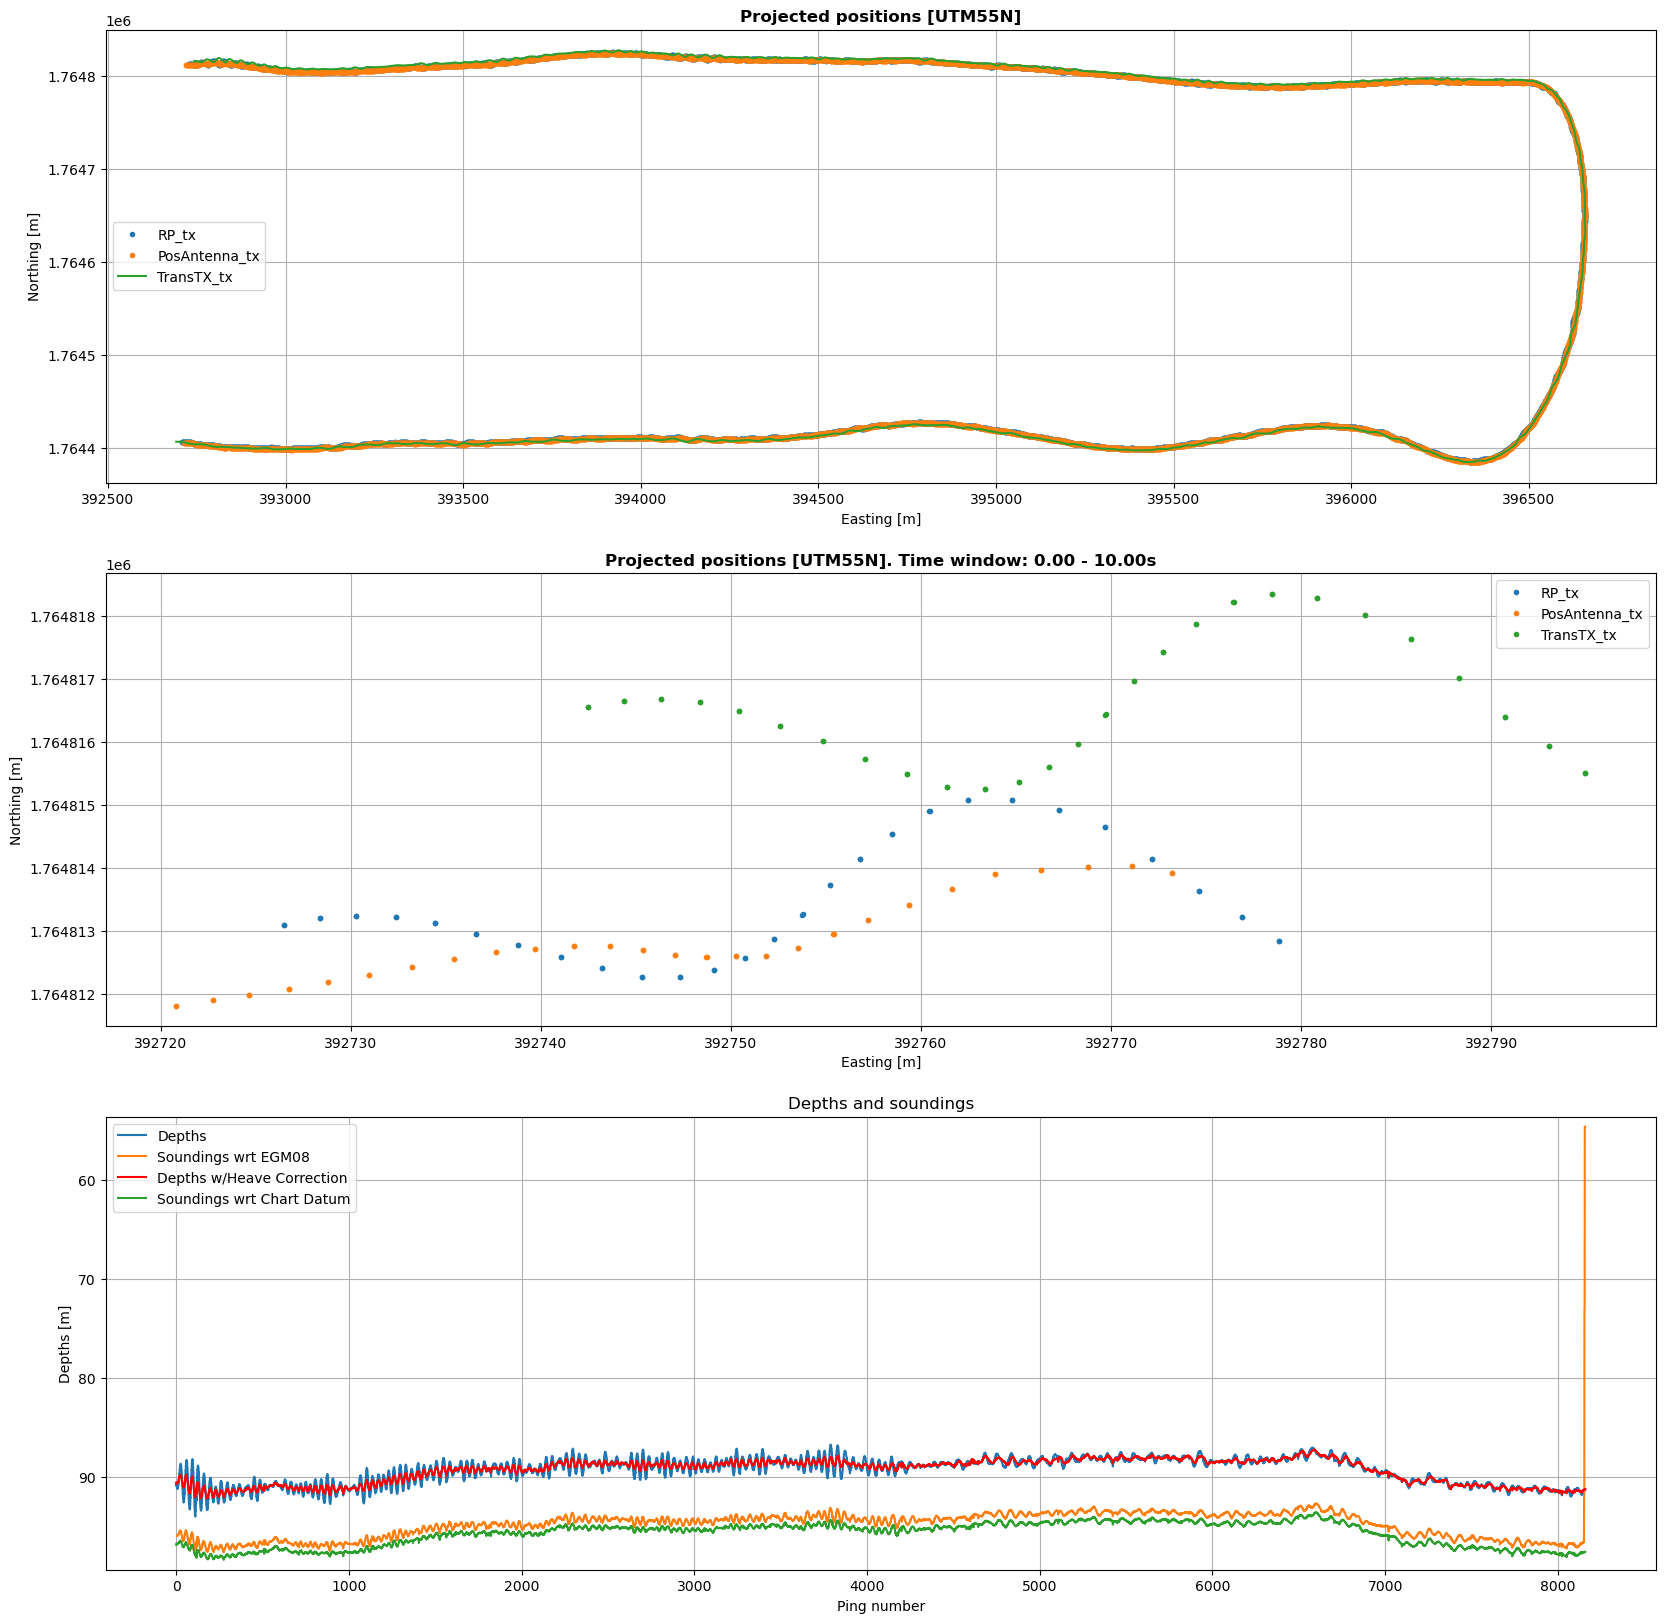

In [100]:
integration=Integration(twtt, pos, motions, sound_speed_profile, water_levels, vessel)
integration.draw()

***

<span style="background-color:red"> 

    
    self.sounding_wl = np.copy(self.depth)
    self.sounding_wl += (self.h_tx + self.h_rx) / 2 + \
         (self.lever_arm_rec_rx[2, :] + self.lever_arm_trans_tx[2, :]) / 2 + \
         - (self.wl_tx + self.wl_rx)/2 - self.vessel.wl

</span>

DELIVERABLE: In a word document submitted on mycourses explain the above bit of code; address all the variables used and define the direction associated to them (gravity, anti gravity, vessel up, down, etc)

In that same document explain the benefit of using the projected UTM coordinates vs. the geodetic latitudes and longitudes.

At the hand of the plots generated by the code cell above, explain why you think you have gotten the translations of steps A8.2.13 and A8.2.14 correct

Finally, explain why there is an offset between the soundings with respect to EGM08 vs. the soundings with respect to MSL

<img align="left" width="6%" style="padding-right:10px; padding-top:10px;" src="./Images/refs.png">

## Useful References

* [The official Python 3.9 documentation](https://docs.python.org/3.9/index.html)
  * [Classes](https://docs.python.org/3.9/tutorial/classes.html)
  * [String Representation Method](https://docs.python.org/3.9/reference/datamodel.html?highlight=repr#object.__str__)
* [Memory address](https://en.wikipedia.org/wiki/Memory_address)
* [ePOM: Programming Basics with Python](https://github.com/hydroffice/python_basics)
* [ePOM: Foundations of Ocean Data Science](../ocean_data_science)
* [Matplotlib](https://matplotlib.org)
* [Cartopy](https://scitools.org.uk/cartopy/docs/latest/)
* [PROJ](https://proj.org/)



<img align="left" width="5%" style="padding-right:10px;" src="./Images/email.png">

*For issues or suggestions related to this notebook that should not be addressed on Teams, write to: semmed@ccom.unh.edu*

Lab A Created by John E. Hughes Clarke<br>
Python code and Notebook implementation by Semme J. Dijkstra